# H3K27ac extra

* Percentiles based analysis
* Wiggle and noise mixtures
* Jaccard MACS2 broad vs SPAN investigation

In [510]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import seaborn as sns
from IPython.display import display
from tqdm.auto import tqdm

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import numpy as np
import os

In [511]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file


def d(a, b):
    return a / b if b != 0 else 0

def last_col(file):
    try:
        cols = len(pd.read_csv(file, sep='\t', nrows=1, header=None).columns)
        return pd.read_csv(file, sep='\t', header=None, usecols=[cols - 1])[cols - 1]
    except:
        return np.zeros(0)  # Empty file

def sorted_file(file):
    ts = tempfile.mktemp()
    !cat {file} | sort -k1,1 -k2,2n > {ts}
    return ts

# Load hg38 peaks


In [512]:
GSE26320_PATH_HG38 = os.path.expanduser('~/data/2023_GSE26320')
# GSE26320_PATH_HG38 = os.path.expanduser('~/data/2023_GSE26320_no_control')
GSE26320_CELLS = ['GM12878', 'HMEC', 'HSMM', 'K562', 'NHEK', 'NHLF', 'H1', 'Huvec', 'HepG2']
# GSE26320_CELLS = ['GM12878',  'K562', 'H1']
# GSE26320_MODIFICATIONS = ['CTCF', 'H3K27ac', 'H3K27me3', 'H3K36me3', 'H3K4me1', 'H3K4me2', 'H3K4me3', 'H3K9ac', 'H4K20me1']
GSE26320_MODIFICATIONS = ['H3K27ac']
GSE26320_REPS = ['rep1', 'rep2']

! mkdir -p {GSE26320_PATH_HG38}/pics

In [452]:
def load_peaks(path, suffix,
               modifications=GSE26320_MODIFICATIONS,
               cells=GSE26320_CELLS,
               replicates=GSE26320_REPS):
    df_fdr = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate', 'peaks', 'avlength'],
                          dtype=object)
    for f in tqdm(os.listdir(path)):
        if not f.endswith(suffix):
            continue
        cell = next((c for c in cells if c in f), None)
        mod = next((m for m in modifications if m in f), None)
        rep = next((r for r in replicates if r in f), None)
        if cell and mod and rep is not None:
            peaks_path = os.path.join(path, f)
            ps, ls = lines(peaks_path), bedl(peaks_path)
            avls = 0 if ps == 0 else sum(ls) / ps
            df_fdr.loc[len(df_fdr)] = (peaks_path, mod, cell, rep, ps, avls)
    return df_fdr

In [517]:
df_macs2 = load_peaks(os.path.join(GSE26320_PATH_HG38, 'macs2'), '.narrowPeak')
df_macs2['tool'] = 'MACS2'
print('MACS2', len(df_macs2))

df_macs2broad = load_peaks(os.path.join(GSE26320_PATH_HG38, 'macs2'), '.broadPeak')
df_macs2broad['tool'] = 'MACS2 broad'
print('MACS2 broad', len(df_macs2broad))

df_sicer = load_peaks(os.path.join(GSE26320_PATH_HG38, 'sicer'), 'summary-FDR0.01')
# df_fdr_sicer = load_peaks_fdr(os.path.join(GSE26320_PATH_HG38, 'sicer'), '.scoreisland', ['0.01'])
df_sicer['tool'] = 'SICER'
print('SICER', len(df_sicer))

df_span = load_peaks(os.path.join(GSE26320_PATH_HG38, 'span'), '.peak')
df_span['tool'] = 'SPAN'
print('SPAN', len(df_span))

TOOLS = ['MACS2', 'MACS2 broad', 'SICER', 'SPAN']
df_peaks = pd.concat([df_macs2, df_macs2broad, df_sicer, df_span]).reset_index(drop=True)

df_peaks['original_file'] = df_peaks['file']

df_peaks.sample(5)

  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 17


  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 broad 17


  0%|          | 0/251 [00:00<?, ?it/s]

SICER 17


  0%|          | 0/88 [00:00<?, ?it/s]

SPAN 17


,file,modification,cell,replicate,peaks,avlength,tool,original_file
9,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K27ac,GM12878,rep1,47290,885.814401,MACS2,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...
44,/home/jetbrains/data/2023_GSE26320/sicer/GSM64...,H3K27ac,HSMM,rep2,41796,2852.579290,SICER,/home/jetbrains/data/2023_GSE26320/sicer/GSM64...
20,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K27ac,K562,rep1,39486,1439.443347,MACS2 broad,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...
12,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K27ac,Huvec,rep2,35178,646.621809,MACS2,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...
30,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K27ac,GM12878,rep2,28199,2039.621334,MACS2 broad,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...


In [518]:
TOOLS = ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
palette = plt.cm.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

# Update peaks to contain only percentile only

In [157]:
step = 20
for percentage in [0, 20, 40, 60, 80]:
    percentage_name = f'{percentage}%-{percentage + step}%'
    ! mkdir -p {GSE26320_PATH_HG38}/percentiles/{percentage_name}
    print(percentage_name)
    percentile_files = []
    for file, cell, replicate in tqdm(zip(df_peaks['file'], df_peaks['cell'], df_peaks['replicate'])):
        union_path = f'{GSE26320_PATH_HG38}/union/H3K27ac_{cell}_{replicate}.bed'
        t = pd.read_csv(union_path, sep='\t', header=None, usecols=[0, 1, 2])
        t[3] = t[2] - t[1]
        t.sort_values(by=[3, 0, 1, 2], inplace=True)
    
        pf = f'{GSE26320_PATH_HG38}/percentiles/{percentage_name}_H3K27ac_{cell}_{replicate}.bed'
        # Take % peaks by lengths and compute ratios inside
        t.iloc[int(len(t) * percentage / 100):int(len(t) * (percentage + step) / 100)][[0, 1, 2]].to_csv(
            pf, sep='\t', index=False, header=None
        )
        # Prepare percentage
        file_perc = f'{GSE26320_PATH_HG38}/percentiles/{percentage_name}/{os.path.basename(file)}' 
        print(percentage_name, cell, replicate, file_perc)
        ! bedtools intersect -wa -u -a {sorted_file(file)} -b {sorted_file(pf)} > {file_perc}
        percentile_files.append(file_perc)
    df_peaks[percentage_name] = percentile_files

df_peaks.sample(5)

0%-20%


0it [00:00, ?it/s]

0%-20% HepG2 rep2 /home/jetbrains/data/2023_GSE26320/percentiles/0%-20%/GSM646356_HepG2_H3K27ac_rep2_q0.05_peaks.narrowPeak
0%-20% GM12878 rep2 /home/jetbrains/data/2023_GSE26320/percentiles/0%-20%/GSM646317_GM12878_H3K27ac_rep2_q0.05_peaks.narrowPeak
0%-20% H1 rep1 /home/jetbrains/data/2023_GSE26320/percentiles/0%-20%/GSM646336_H1_H3K27ac_rep1_q0.05_peaks.narrowPeak
0%-20% NHLF rep2 /home/jetbrains/data/2023_GSE26320/percentiles/0%-20%/GSM646477_NHLF_H3K27ac_rep2_q0.05_peaks.narrowPeak
0%-20% HepG2 rep1 /home/jetbrains/data/2023_GSE26320/percentiles/0%-20%/GSM646355_HepG2_H3K27ac_rep1_q0.05_peaks.narrowPeak
0%-20% K562 rep1 /home/jetbrains/data/2023_GSE26320/percentiles/0%-20%/GSM646434_K562_H3K27ac_rep1_q0.05_peaks.narrowPeak
0%-20% HSMM rep2 /home/jetbrains/data/2023_GSE26320/percentiles/0%-20%/GSM646395_HSMM_H3K27ac_rep2_q0.05_peaks.narrowPeak
0%-20% Huvec rep1 /home/jetbrains/data/2023_GSE26320/percentiles/0%-20%/GSM646414_Huvec_H3K27ac_rep1_q0.05_peaks.narrowPeak
0%-20% HSMM rep1

0it [00:00, ?it/s]

20%-40% HepG2 rep2 /home/jetbrains/data/2023_GSE26320/percentiles/20%-40%/GSM646356_HepG2_H3K27ac_rep2_q0.05_peaks.narrowPeak
20%-40% GM12878 rep2 /home/jetbrains/data/2023_GSE26320/percentiles/20%-40%/GSM646317_GM12878_H3K27ac_rep2_q0.05_peaks.narrowPeak
20%-40% H1 rep1 /home/jetbrains/data/2023_GSE26320/percentiles/20%-40%/GSM646336_H1_H3K27ac_rep1_q0.05_peaks.narrowPeak
20%-40% NHLF rep2 /home/jetbrains/data/2023_GSE26320/percentiles/20%-40%/GSM646477_NHLF_H3K27ac_rep2_q0.05_peaks.narrowPeak
20%-40% HepG2 rep1 /home/jetbrains/data/2023_GSE26320/percentiles/20%-40%/GSM646355_HepG2_H3K27ac_rep1_q0.05_peaks.narrowPeak
20%-40% K562 rep1 /home/jetbrains/data/2023_GSE26320/percentiles/20%-40%/GSM646434_K562_H3K27ac_rep1_q0.05_peaks.narrowPeak
20%-40% HSMM rep2 /home/jetbrains/data/2023_GSE26320/percentiles/20%-40%/GSM646395_HSMM_H3K27ac_rep2_q0.05_peaks.narrowPeak
20%-40% Huvec rep1 /home/jetbrains/data/2023_GSE26320/percentiles/20%-40%/GSM646414_Huvec_H3K27ac_rep1_q0.05_peaks.narrowPeak


0it [00:00, ?it/s]

40%-60% HepG2 rep2 /home/jetbrains/data/2023_GSE26320/percentiles/40%-60%/GSM646356_HepG2_H3K27ac_rep2_q0.05_peaks.narrowPeak
40%-60% GM12878 rep2 /home/jetbrains/data/2023_GSE26320/percentiles/40%-60%/GSM646317_GM12878_H3K27ac_rep2_q0.05_peaks.narrowPeak
40%-60% H1 rep1 /home/jetbrains/data/2023_GSE26320/percentiles/40%-60%/GSM646336_H1_H3K27ac_rep1_q0.05_peaks.narrowPeak
40%-60% NHLF rep2 /home/jetbrains/data/2023_GSE26320/percentiles/40%-60%/GSM646477_NHLF_H3K27ac_rep2_q0.05_peaks.narrowPeak
40%-60% HepG2 rep1 /home/jetbrains/data/2023_GSE26320/percentiles/40%-60%/GSM646355_HepG2_H3K27ac_rep1_q0.05_peaks.narrowPeak
40%-60% K562 rep1 /home/jetbrains/data/2023_GSE26320/percentiles/40%-60%/GSM646434_K562_H3K27ac_rep1_q0.05_peaks.narrowPeak
40%-60% HSMM rep2 /home/jetbrains/data/2023_GSE26320/percentiles/40%-60%/GSM646395_HSMM_H3K27ac_rep2_q0.05_peaks.narrowPeak
40%-60% Huvec rep1 /home/jetbrains/data/2023_GSE26320/percentiles/40%-60%/GSM646414_Huvec_H3K27ac_rep1_q0.05_peaks.narrowPeak


0it [00:00, ?it/s]

60%-80% HepG2 rep2 /home/jetbrains/data/2023_GSE26320/percentiles/60%-80%/GSM646356_HepG2_H3K27ac_rep2_q0.05_peaks.narrowPeak
60%-80% GM12878 rep2 /home/jetbrains/data/2023_GSE26320/percentiles/60%-80%/GSM646317_GM12878_H3K27ac_rep2_q0.05_peaks.narrowPeak
60%-80% H1 rep1 /home/jetbrains/data/2023_GSE26320/percentiles/60%-80%/GSM646336_H1_H3K27ac_rep1_q0.05_peaks.narrowPeak
60%-80% NHLF rep2 /home/jetbrains/data/2023_GSE26320/percentiles/60%-80%/GSM646477_NHLF_H3K27ac_rep2_q0.05_peaks.narrowPeak
60%-80% HepG2 rep1 /home/jetbrains/data/2023_GSE26320/percentiles/60%-80%/GSM646355_HepG2_H3K27ac_rep1_q0.05_peaks.narrowPeak
60%-80% K562 rep1 /home/jetbrains/data/2023_GSE26320/percentiles/60%-80%/GSM646434_K562_H3K27ac_rep1_q0.05_peaks.narrowPeak
60%-80% HSMM rep2 /home/jetbrains/data/2023_GSE26320/percentiles/60%-80%/GSM646395_HSMM_H3K27ac_rep2_q0.05_peaks.narrowPeak
60%-80% Huvec rep1 /home/jetbrains/data/2023_GSE26320/percentiles/60%-80%/GSM646414_Huvec_H3K27ac_rep1_q0.05_peaks.narrowPeak


0it [00:00, ?it/s]

80%-100% HepG2 rep2 /home/jetbrains/data/2023_GSE26320/percentiles/80%-100%/GSM646356_HepG2_H3K27ac_rep2_q0.05_peaks.narrowPeak
80%-100% GM12878 rep2 /home/jetbrains/data/2023_GSE26320/percentiles/80%-100%/GSM646317_GM12878_H3K27ac_rep2_q0.05_peaks.narrowPeak
80%-100% H1 rep1 /home/jetbrains/data/2023_GSE26320/percentiles/80%-100%/GSM646336_H1_H3K27ac_rep1_q0.05_peaks.narrowPeak
80%-100% NHLF rep2 /home/jetbrains/data/2023_GSE26320/percentiles/80%-100%/GSM646477_NHLF_H3K27ac_rep2_q0.05_peaks.narrowPeak
80%-100% HepG2 rep1 /home/jetbrains/data/2023_GSE26320/percentiles/80%-100%/GSM646355_HepG2_H3K27ac_rep1_q0.05_peaks.narrowPeak
80%-100% K562 rep1 /home/jetbrains/data/2023_GSE26320/percentiles/80%-100%/GSM646434_K562_H3K27ac_rep1_q0.05_peaks.narrowPeak
80%-100% HSMM rep2 /home/jetbrains/data/2023_GSE26320/percentiles/80%-100%/GSM646395_HSMM_H3K27ac_rep2_q0.05_peaks.narrowPeak
80%-100% Huvec rep1 /home/jetbrains/data/2023_GSE26320/percentiles/80%-100%/GSM646414_Huvec_H3K27ac_rep1_q0.05_p

,file,modification,cell,replicate,fdr,peaks,avlength,tool,original_file,0%-20%,20%-40%,40%-60%,60%-80%,80%-100%
8,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K27ac,HMEC,rep1,0.1,29088,1385.748934,MACS2 broad,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...
15,/home/jetbrains/data/2023_GSE26320/span/GSM646...,H3K27ac,GM12878,rep1,0.05,34842,2249.681964,SPAN,/home/jetbrains/data/2023_GSE26320/span/GSM646...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...
3,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K27ac,K562,rep1,0.1,39486,1439.443347,MACS2 broad,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...
1,/home/jetbrains/data/2023_GSE26320/span/GSM646...,H3K27ac,HSMM,rep1,0.05,38858,1544.996088,SPAN,/home/jetbrains/data/2023_GSE26320/span/GSM646...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...
6,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K27ac,H1,rep1,0.1,15680,1062.139732,MACS2 broad,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...


# Coverage for the given percentile settings

In [173]:
# Compute coverage on given percentile settings
# df_fdr_peaks['file'] = df_fdr_peaks['0%-20%']
# df_fdr_peaks['file'] = df_fdr_peaks['40%-60%']
df_peaks['file'] = df_peaks['80%-100%']

In [174]:
# Fraction of reads in peaks
GSE26320_PATH_HG38_BW = GSE26320_PATH_HG38 + '/bw'


def load_bws(path, m):
    df_bws = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if '.bw' not in f:
            continue
        cell = next((cc for cc in GSE26320_CELLS if cc in f), None)
        rep = next((r for r in GSE26320_REPS if r in f), None)
        if cell and rep and m in f:
            df_bws.loc[len(df_bws)] = ((os.path.join(path, f)), m, cell, rep)
    return df_bws

In [175]:
bws_df = load_bws(GSE26320_PATH_HG38_BW, 'H3K27ac')
display(bws_df.sample(3))
bws_control_df = load_bws(GSE26320_PATH_HG38_BW, 'Input')
display(bws_control_df.sample(3))

  0%|          | 0/103 [00:00<?, ?it/s]

,file,modification,cell,replicate
8,/home/jetbrains/data/2023_GSE26320/bw/GSM64633...,H3K27ac,H1,rep1
2,/home/jetbrains/data/2023_GSE26320/bw/GSM64635...,H3K27ac,HepG2,rep1
16,/home/jetbrains/data/2023_GSE26320/bw/GSM64631...,H3K27ac,GM12878,rep1


  0%|          | 0/103 [00:00<?, ?it/s]

,file,modification,cell,replicate
5,/home/jetbrains/data/2023_GSE26320/bw/GSM64645...,Input,K562,rep2
11,/home/jetbrains/data/2023_GSE26320/bw/GSM64637...,Input,HepG2,rep1
9,/home/jetbrains/data/2023_GSE26320/bw/GSM64639...,Input,HMEC,rep2


In [176]:
CHROM_SIZES = {
    c: s for _, (c, s) in pd.read_csv(os.path.join(GSE26320_PATH_HG38, 'hg38.chrom.sizes'),
                                      sep='\t', names=['chr', 'size']).iterrows() if '_' not in c
}

## FRIP

In [177]:
import pyBigWig
import tempfile
from itertools import product

tf = tempfile.mktemp()

frip_df = pd.DataFrame(
    columns=['cell', 'replicate', 'bw_file', 'tool', 'peaks_file', 'peaks', 'length',
             'reads_in_peaks', 'all_reads', 'control_reads_in_peaks', 'control_all_reads'],
    dtype=object
)

for c, r in tqdm(product(GSE26320_CELLS, GSE26320_REPS)):
    # for c, r in tqdm(product(['GM12878'], ['rep1'])):
    print(c, r)
    for tool in set(df_peaks['tool']):
        t = df_peaks[(df_peaks['tool'] == tool) & (df_peaks['modification'] == 'H3K27ac') &
                     (df_peaks['cell'] == c) & (df_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        peaks = lines(peaks_file)
        if peaks == 0:
            continue
        peaks_len = int(bedl(peaks_file).sum())
        t = bws_df[(bws_df['modification'] == 'H3K27ac') &
                   (bws_df['cell'] == c) & (bws_df['replicate'] == r)]
        if len(t) == 0:
            continue
        bw_file = t['file'].values[0]
        t = bws_control_df[(bws_control_df['cell'] == c) & (bws_control_df['replicate'] == r)]
        if len(t) == 0:
            continue
        bw_control_file = t['file'].values[0]

        print(tool, peaks_file, bw_file, bw_control_file)
        t = pd.read_csv(peaks_file, sep='\t', header=None)
        with pyBigWig.open(bw_file) as bw:
            total_coverage = sum(bw.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique())
            peaks_coverage = sum(bw.stats(chr, start, end, type='sum', exact=True)[0]
                                 for chr, start, end in zip(t[0], t[1], t[2]))
        with pyBigWig.open(bw_control_file) as bwc:
            control_total_coverage = sum(
                bwc.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique() if chr in CHROM_SIZES)
            control_peaks_coverage = sum(bwc.stats(chr, start, end, type='sum', exact=True)[0]
                                         for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES)
        frip_df.loc[len(frip_df)] = (c, r, bw_file, tool, peaks_file, peaks, peaks_len,
                                     peaks_coverage, total_coverage, control_peaks_coverage, control_total_coverage)

frip_df

0it [00:00, ?it/s]

GM12878 rep1
MACS2 broad /tmp/tmprqahzhxc /home/jetbrains/data/2023_GSE26320/bw/GSM646316_GM12878_H3K27ac_rep1.bw /home/jetbrains/data/2023_GSE26320/bw/GSM646332_GM12878_Input_rep1.bw
SICER /tmp/tmprraolm51 /home/jetbrains/data/2023_GSE26320/bw/GSM646316_GM12878_H3K27ac_rep1.bw /home/jetbrains/data/2023_GSE26320/bw/GSM646332_GM12878_Input_rep1.bw
SPAN /tmp/tmpe3hmtssj /home/jetbrains/data/2023_GSE26320/bw/GSM646316_GM12878_H3K27ac_rep1.bw /home/jetbrains/data/2023_GSE26320/bw/GSM646332_GM12878_Input_rep1.bw
MACS2 /tmp/tmpz82qrkmg /home/jetbrains/data/2023_GSE26320/bw/GSM646316_GM12878_H3K27ac_rep1.bw /home/jetbrains/data/2023_GSE26320/bw/GSM646332_GM12878_Input_rep1.bw
GM12878 rep2
MACS2 broad /tmp/tmp4k6bgrlx /home/jetbrains/data/2023_GSE26320/bw/GSM646317_GM12878_H3K27ac_rep2.bw /home/jetbrains/data/2023_GSE26320/bw/GSM646333_GM12878_Input_rep2.bw
SICER /tmp/tmpwen4vyau /home/jetbrains/data/2023_GSE26320/bw/GSM646317_GM12878_H3K27ac_rep2.bw /home/jetbrains/data/2023_GSE26320/bw/GSM64

,cell,replicate,bw_file,tool,peaks_file,peaks,length,reads_in_peaks,all_reads,control_reads_in_peaks,control_all_reads
0,GM12878,rep1,/home/jetbrains/data/2023_GSE26320/bw/GSM64631...,MACS2 broad,/tmp/tmprqahzhxc,9876,37160619,3.341714e+07,9.601462e+07,1.872251e+06,9.856627e+07
1,GM12878,rep1,/home/jetbrains/data/2023_GSE26320/bw/GSM64631...,SICER,/tmp/tmprraolm51,6852,59606548,3.652669e+07,9.599063e+07,3.078541e+06,9.856627e+07
2,GM12878,rep1,/home/jetbrains/data/2023_GSE26320/bw/GSM64631...,SPAN,/tmp/tmpe3hmtssj,9371,43509707,3.474764e+07,9.601462e+07,2.326831e+06,9.856627e+07
3,GM12878,rep1,/home/jetbrains/data/2023_GSE26320/bw/GSM64631...,MACS2,/tmp/tmpz82qrkmg,22421,25203861,3.004449e+07,9.601462e+07,1.228969e+06,9.856627e+07
4,GM12878,rep2,/home/jetbrains/data/2023_GSE26320/bw/GSM64631...,MACS2 broad,/tmp/tmp4k6bgrlx,8985,33108223,3.251897e+07,9.689406e+07,1.806492e+06,9.837757e+07
...,...,...,...,...,...,...,...,...,...,...,...
63,HepG2,rep1,/home/jetbrains/data/2023_GSE26320/bw/GSM64635...,MACS2,/tmp/tmp2yrglwy8,21306,21881553,2.434796e+07,7.922325e+07,1.154439e+06,8.086781e+07
64,HepG2,rep2,/home/jetbrains/data/2023_GSE26320/bw/GSM64635...,MACS2 broad,/tmp/tmp7f1nfuge,6860,15149703,2.661855e+07,8.126260e+07,3.541297e+05,8.412824e+07
65,HepG2,rep2,/home/jetbrains/data/2023_GSE26320/bw/GSM64635...,SICER,/tmp/tmpzgpqikoo,5576,41936624,3.314373e+07,8.126260e+07,1.456920e+06,8.412824e+07
66,HepG2,rep2,/home/jetbrains/data/2023_GSE26320/bw/GSM64635...,SPAN,/tmp/tmpmyy6jgbj,7071,29478482,3.156573e+07,8.126260e+07,1.014165e+06,8.412824e+07


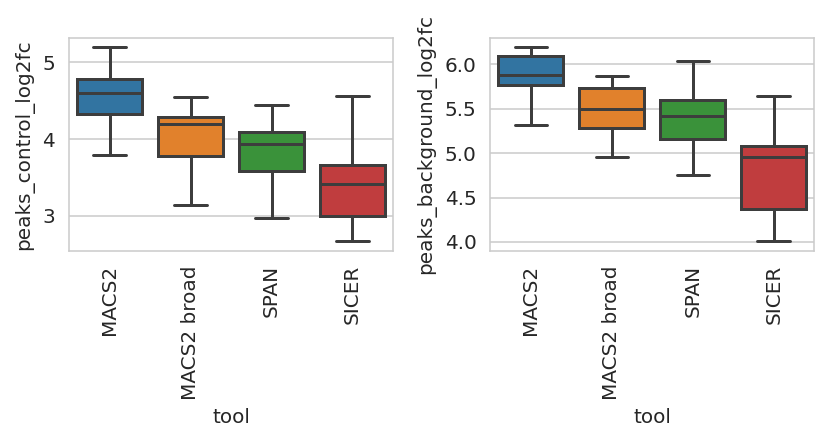

In [178]:
frip_df['peaks_background_log2fc'] = [
    np.log2((x / (z + 1e-10)) / ((y - x) / (sum(CHROM_SIZES.values()) - z + 1e-10)))
    for x, y, z in zip(frip_df['reads_in_peaks'], frip_df['all_reads'], frip_df['length'])
]
frip_df['peaks_control_log2fc'] = [
    np.log2(d(x / ((y + 1e-10) / 1e6), z / ((u + 1e-10) / 1e6) + 1e-10))
    for x, y, z, u in zip(frip_df['reads_in_peaks'], frip_df['all_reads'],
                          frip_df['control_reads_in_peaks'], frip_df['control_all_reads'])
]

import seaborn as sns

t = frip_df

plt.figure(figsize=(6, 3))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
ax = axs[0]
g_results = sns.boxplot(data=t, x='tool', y='peaks_control_log2fc',
                        palette=TOOLS_PALETTE,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        showfliers=False,
                        ax=ax)
ax.xaxis.set_tick_params(rotation=90)

ax = axs[1]
g_results = sns.boxplot(data=t, x='tool', y='peaks_background_log2fc',
                        palette=TOOLS_PALETTE,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        showfliers=False,
                        ax=ax)
ax.xaxis.set_tick_params(rotation=90)
plt.tight_layout()

plt.show()

# Prepare datasets with wiggling and mixing control data into signal track

## Wiggle bed files

In [550]:
WD = os.path.expanduser('~/data/2023_GSE26320_wiggle_mix')
tf1 = tempfile.mktemp()
tf2 = tempfile.mktemp()
bed = os.path.expanduser(f'{WD}/original_bams/GSM646316_GM12878_H3K27ac_rep1.bed')

## Wiggle all coverage

In [551]:
t = pd.read_csv(bed, sep='\t', header=None)
print('Reads', len(t))
t.sample(5)

Reads 7049058


,0,1,2,3,4,5
1158945,chr22,26589969,26590020,SRR094196.24549657,42,-
669151,chr7,104896644,104896695,SRR094196.11298211,40,-
4904360,chrX,42840038,42840089,SRR094196.6475824,42,-
5247917,chr1,55253588,55253639,SRR094196.26918135,42,-
1255102,chr22,50470254,50470305,SRR094196.26510779,42,+


In [552]:
signal = t.sample(int(len(t) * 0.8))
noise = t.sample(int(len(t) * 0.2))
delta = [int(x) for x in np.random.normal(0, 5_000, size=len(noise))]
noise[1] += delta
noise[2] += delta
# Ensure generated reads have proper coordinates
noise.loc[noise[1] < 1, 1] = 1
noise.loc[noise[2] < 1, 2] = 1

signal.to_csv(tf1, sep='\t', index=False, header=None)
noise.to_csv(tf2, sep='\t', index=False, header=None)

In [553]:
result_file = f'{WD}/GSM646316_GM12878_H3K27ac_rep1_wiggle.bed'
! cat {tf1} > {result_file}
! cat {tf2} >> {result_file}

In [554]:
del t, signal, noise, delta

## Mixing with input

In [555]:
signal = pd.read_csv(bed, sep='\t', header=None)
reads = len(signal)
print('Reads', reads)
signal.sample(5)

Reads 7049058


,0,1,2,3,4,5
5389745,chr1,119140346,119140397,SRR094196.15769343,42,+
645098,chr7,98771910,98771961,SRR094196.23160537,42,-
5664714,chr1,235887902,235887953,SRR094196.21598322,42,+
301082,chr16,23849307,23849358,SRR094196.26877727,42,+
6961027,chr2,214358552,214358603,SRR094196.1450009,42,-


In [556]:
input = f'{WD}/original_bams/GSM646332_GM12878_Input_rep1.bed'
noise = pd.read_csv(input, sep='\t', header=None)
noise.sample(5)

,0,1,2,3,4,5
2122653,chr17,15407971,15408022,SRR094215.3034868,30,-
4381414,chr1,154423356,154423407,SRR094215.7853914,42,+
4620802,chr6,10950576,10950627,SRR094215.4129694,40,-
1601697,chr8,16303343,16303394,SRR094215.6736361,42,+
4143347,chr1,14059259,14059310,SRR094215.8986254,30,-


In [557]:
signal = signal.sample(int(reads * 0.5))
noise = noise.sample(int(reads * 0.5))
signal.to_csv(tf1, sep='\t', index=False, header=None)
noise.to_csv(tf2, sep='\t', index=False, header=None)
result_file = f'{WD}/GSM646316_GM12878_H3K27ac_rep1_mix.bed'
! cat {tf1} > {result_file}
! cat {tf2} >> {result_file}

In [558]:
del signal, noise

# Lengths distribution in noise conditions

Please rerun snakemake smk-chipseq-pipeline for mix and wiggle tracks.

In [559]:
k27ac_peaks = df_peaks[(df_peaks['modification'] == 'H3K27ac') &
                       (df_peaks['cell'] == 'GM12878') &
                       (df_peaks['replicate'] == 'rep1')].copy()
k27ac_peaks['file'] = k27ac_peaks['original_file']
k27ac_peaks['name'] = k27ac_peaks['tool']
k27ac_peaks['type'] = 'base'
k27ac_peaks

,file,modification,cell,replicate,peaks,avlength,tool,original_file,name,type
9,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K27ac,GM12878,rep1,47290,885.814401,MACS2,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,MACS2,base
32,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K27ac,GM12878,rep1,31476,2079.336892,MACS2 broad,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,MACS2 broad,base
43,/home/jetbrains/data/2023_GSE26320/sicer/GSM64...,H3K27ac,GM12878,rep1,32861,3777.138219,SICER,/home/jetbrains/data/2023_GSE26320/sicer/GSM64...,SICER,base
66,/home/jetbrains/data/2023_GSE26320/span/GSM646...,H3K27ac,GM12878,rep1,34842,2249.681964,SPAN,/home/jetbrains/data/2023_GSE26320/span/GSM646...,SPAN,base


In [595]:
df_macs2 = load_peaks(os.path.join(WD, 'macs2'), '.narrowPeak')
df_macs2['tool'] = 'MACS2'
print('MACS2', len(df_macs2))

df_macs2broad = load_peaks(os.path.join(WD, 'macs2'), '.broadPeak')
df_macs2broad['tool'] = 'MACS2 broad'
print('MACS2 broad', len(df_macs2broad))

df_sicer = load_peaks(os.path.join(WD, 'sicer'), 'summary-FDR0.01')
# df_fdr_sicer = load_peaks_fdr(os.path.join(GSE26320_PATH_HG38, 'sicer'), '.scoreisland', ['0.01'])
df_sicer['tool'] = 'SICER'
print('SICER', len(df_sicer))

df_span = load_peaks(os.path.join(WD, 'span'), '.peak')
df_span['tool'] = 'SPAN'
print('SPAN', len(df_span))

df_peaks_mix_wiggle = pd.concat([k27ac_peaks, df_macs2, df_macs2broad, df_sicer, df_span])
df_peaks_mix_wiggle['name'] = df_peaks_mix_wiggle['tool'] 
df_peaks_mix_wiggle['type'] = 'base'

mix_rows = ['mix' in os.path.basename(f) for f in df_peaks_mix_wiggle['file']]
wiggle_rows = ['wiggle' in os.path.basename(f) for f in df_peaks_mix_wiggle['file']]
df_peaks_mix_wiggle.loc[mix_rows, 'name'] = df_peaks_mix_wiggle[mix_rows]['name'] + ' mix'
df_peaks_mix_wiggle.loc[mix_rows, 'type'] = 'mix'
df_peaks_mix_wiggle.loc[wiggle_rows, 'name'] = df_peaks_mix_wiggle[wiggle_rows]['name'] + ' wiggle'
df_peaks_mix_wiggle.loc[wiggle_rows, 'type'] = 'wiggle'
df_peaks_mix_wiggle

  0%|          | 0/16 [00:00<?, ?it/s]

MACS2 2


  0%|          | 0/16 [00:00<?, ?it/s]

MACS2 broad 2


  0%|          | 0/2 [00:00<?, ?it/s]

SICER 2


  0%|          | 0/5 [00:00<?, ?it/s]

SPAN 2


,file,modification,cell,replicate,peaks,avlength,tool,original_file,name,type
9,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K27ac,GM12878,rep1,47290,885.814401,MACS2,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,MACS2,base
32,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K27ac,GM12878,rep1,31476,2079.336892,MACS2 broad,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,MACS2 broad,base
43,/home/jetbrains/data/2023_GSE26320/sicer/GSM64...,H3K27ac,GM12878,rep1,32861,3777.138219,SICER,/home/jetbrains/data/2023_GSE26320/sicer/GSM64...,SICER,base
66,/home/jetbrains/data/2023_GSE26320/span/GSM646...,H3K27ac,GM12878,rep1,34842,2249.681964,SPAN,/home/jetbrains/data/2023_GSE26320/span/GSM646...,SPAN,base
0,/home/jetbrains/data/2023_GSE26320_wiggle_mix/...,H3K27ac,GM12878,rep1,30120,684.360458,MACS2,NaN,MACS2 mix,mix
1,/home/jetbrains/data/2023_GSE26320_wiggle_mix/...,H3K27ac,GM12878,rep1,45795,906.872104,MACS2,NaN,MACS2 wiggle,wiggle
0,/home/jetbrains/data/2023_GSE26320_wiggle_mix/...,H3K27ac,GM12878,rep1,27878,969.593837,MACS2 broad,NaN,MACS2 broad mix,mix
1,/home/jetbrains/data/2023_GSE26320_wiggle_mix/...,H3K27ac,GM12878,rep1,40382,1259.350032,MACS2 broad,NaN,MACS2 broad wiggle,wiggle
0,/home/jetbrains/data/2023_GSE26320_wiggle_mix/...,H3K27ac,GM12878,rep1,25568,3790.121715,SICER,NaN,SICER mix,mix
1,/home/jetbrains/data/2023_GSE26320_wiggle_mix/...,H3K27ac,GM12878,rep1,29260,5101.624744,SICER,NaN,SICER wiggle,wiggle


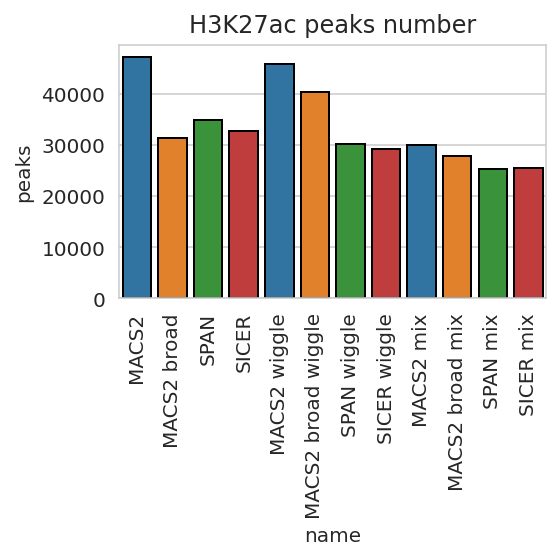

In [596]:
order = [f'{tool}{suffix}' for (suffix, tool) in product(['', ' wiggle', ' mix'],
                                                         ['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])]
palette = {f'{tool}{suffix}': TOOLS_PALETTE[tool]
           for (suffix, tool) in product(['', ' wiggle', ' mix'],
                                         ['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])}

plt.figure(figsize=(4, 4))
ax = plt.axes()
g_results = sns.barplot(data=df_peaks_mix_wiggle, x='name', y='peaks', ax=ax,
                        capsize=.2, errwidth=2, edgecolor="black",
                        palette=palette,
                        order=order)
ax.xaxis.set_tick_params(rotation=90)
ax.title.set_text('H3K27ac peaks number')
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_wiggle_mix_peaks.pdf', bbox_inches='tight', dpi=300)
plt.show()

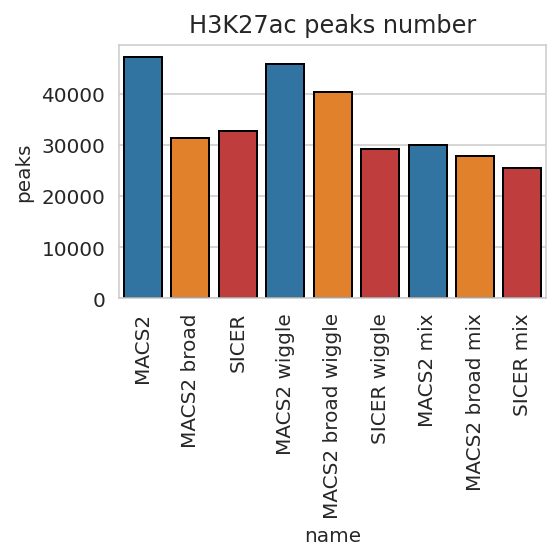

In [597]:
order = [f'{tool}{suffix}' for (suffix, tool) in product(['', ' wiggle', ' mix'],
                                                         ['MACS2', 'MACS2 broad', 'SICER'])]
palette = {f'{tool}{suffix}': TOOLS_PALETTE[tool]
           for (suffix, tool) in product(['', ' wiggle', ' mix'],
                                         ['MACS2', 'MACS2 broad', 'SICER'])}

plt.figure(figsize=(4, 4))
ax = plt.axes()
g_results = sns.barplot(data=df_peaks_mix_wiggle, x='name', y='peaks', ax=ax,
                        capsize=.2, errwidth=2, edgecolor="black",
                        palette=palette,
                        order=order)
ax.xaxis.set_tick_params(rotation=90)
ax.title.set_text('H3K27ac peaks number')
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_wiggle_mix_peaks_nospan.pdf', bbox_inches='tight', dpi=300)
plt.show()

base
wiggle
mix


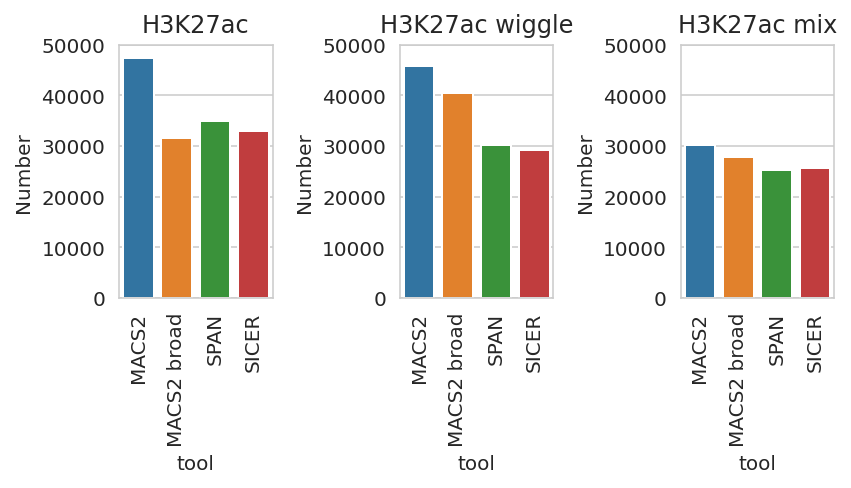

In [598]:
plt.figure(figsize=(6, 3.5))
axs = [plt.subplot(1, 3, i + 1) for i in range(3)]


for i, ty in enumerate(['base', 'wiggle', 'mix']):
    tf = tempfile.mktemp()

    print(ty)
    ax = axs[i]
    g_results = sns.barplot(data=df_peaks_mix_wiggle[df_peaks_mix_wiggle['type'] == ty],
                            x='tool', y='peaks', ax=ax,
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                            palette=TOOLS_PALETTE,
                            )
    if ty != 'base':
        ax.title.set_text(f'H3K27ac {ty}')
    else:
        ax.title.set_text('H3K27ac')
    g_results.axes.set_ylabel('Number')
    ax.set_ylim(0, 50_000)
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
# plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_wiggle_mix_percentiles_no_span.pdf', bbox_inches='tight', dpi=300)
plt.show()

base
wiggle
mix


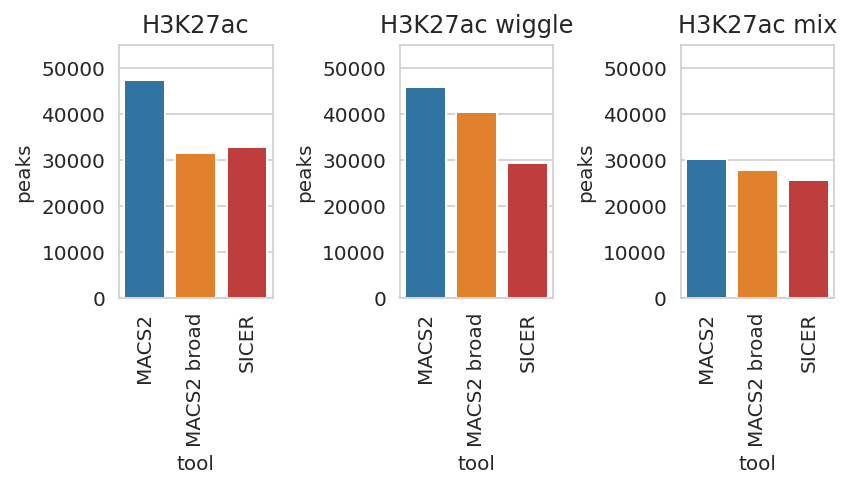

In [599]:
plt.figure(figsize=(6, 3.5))
axs = [plt.subplot(1, 3, i + 1) for i in range(3)]


for i, ty in enumerate(['base', 'wiggle', 'mix']):
    tf = tempfile.mktemp()

    print(ty)
    ax = axs[i]
    g_results = sns.barplot(data=df_peaks_mix_wiggle[df_peaks_mix_wiggle['type'] == ty],
                            x='tool', y='peaks', ax=ax,
                            order=['MACS2', 'MACS2 broad', 'SICER'],
                            palette=TOOLS_PALETTE,
                            )
    if ty != 'base':
        ax.title.set_text(f'H3K27ac {ty}')
    else:
        ax.title.set_text('H3K27ac')
    ax.set_ylim(0, 55_000)
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

MACS2
MACS2 broad
SICER


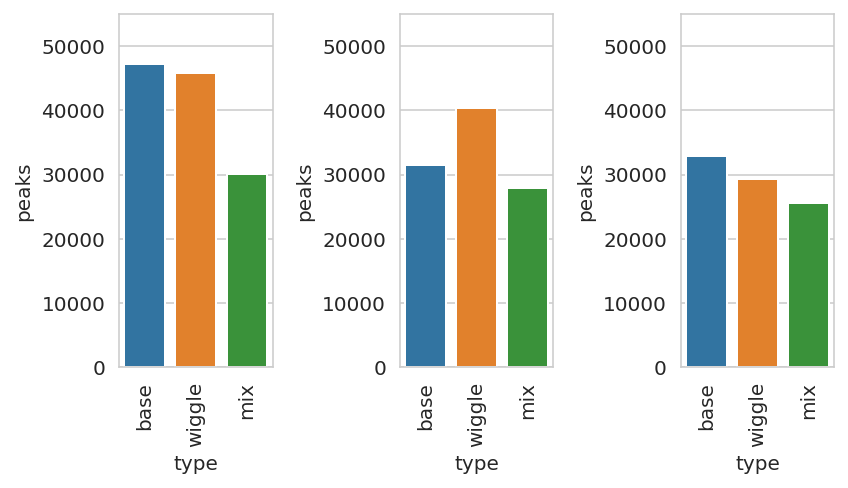

In [602]:
plt.figure(figsize=(6, 3.5))
axs = [plt.subplot(1, 3, i + 1) for i in range(3)]


for i, tool in enumerate(['MACS2', 'MACS2 broad', 'SICER']):
    print(tool)
    ax = axs[i]
    g_results = sns.barplot(data=df_peaks_mix_wiggle[df_peaks_mix_wiggle['tool'] == tool],
                            x='type', y='peaks', ax=ax,
                            order=['base', 'wiggle', 'mix'],
                            )
    ax.set_ylim(0, 55_000)
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

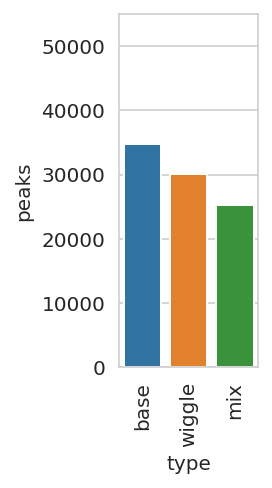

In [605]:
plt.figure(figsize=(2, 3.5))
ax = plt.axes()
g_results = sns.barplot(data=df_peaks_mix_wiggle[df_peaks_mix_wiggle['tool'] == 'SPAN'],
                        x='type', y='peaks', ax=ax,
                        order=['base', 'wiggle', 'mix'],
                        )
ax.set_ylim(0, 55_000)
ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

# Difference between broad and narrow peaks

In [570]:
! mkdir -p {WD}/union

perc_len_dfs = []
perc_peaks_df = pd.DataFrame(columns=['type', 'length', 'tool', 'peaks'], dtype=object)

for ty in tqdm(['base', 'wiggle', 'mix']):
    tf = tempfile.mktemp()

    print(ty)
    t = df_peaks_mix_wiggle[(df_peaks_mix_wiggle['modification'] == 'H3K27ac') &
                            (df_peaks_mix_wiggle['type'] == ty)]
    if len(t) == 0:
        continue
    try:
        t_span = sorted_file(t[t['tool'] == 'SPAN']['file'].values[0])
        t_macs2 = sorted_file(t[t['tool'] == 'MACS2']['file'].values[0])
        t_macs2broad = sorted_file(t[t['tool'] == 'MACS2 broad']['file'].values[0])
        t_sicer = sorted_file(t[t['tool'] == 'SICER']['file'].values[0])
        # Prepare total overlap
        union_path = f'{WD}/union/H3K27ac_{ty}.bed'
        ! bedtools multiinter -i {t_span} {t_macs2} {t_macs2broad} {t_sicer} > {tf}
        ! bedtools merge -i {tf} > {union_path}
        t = pd.read_csv(union_path, sep='\t', header=None, usecols=[0, 1, 2])
        t[3] = t[2] - t[1]
        t.sort_values(by=[3, 0, 1, 2], inplace=True)
        # Take % peaks by lengths and compute ratios inside
        step = 20
        for percentage in [0, 20, 40, 60, 80]:
            percentage_name = f'{percentage}%-{percentage + step}%'
            t.iloc[int(len(t) * percentage / 100):int(len(t) * (percentage + step) / 100)][[0, 1, 2]].to_csv(
                tf, sep='\t', index=False, header=None
            )
            for tool, file in [('MACS2', t_macs2), ('MACS2 broad', t_macs2broad), ('SPAN', t_span), ('SICER', t_sicer)]:
                # Prepare tool percentage peaks
                ! bedtools intersect -wa -u -a {file} -b {sorted_file(tf)} > {file}-perc
                # print(tool)
                # ! wc -l {file}-perc
                peak_lengths = bedl(f'{file}-perc')
                tl = pd.DataFrame(dict(peak_lengths=peak_lengths))
                tl['name'] = tool
                tl['type'] = ty
                tl['length'] = percentage_name
                perc_peaks_df.loc[len(perc_peaks_df)] = (ty, percentage_name, tool, len(peak_lengths))
                perc_len_dfs.append(tl.sample(min(len(tl), 10_000)))

    except Exception as e:
        print(e)

display(perc_peaks_df.sample(3))
perc_len_df = pd.concat(perc_len_dfs).reset_index(drop=True)
del perc_len_dfs
display(perc_len_df.sample(3))

  0%|          | 0/3 [00:00<?, ?it/s]

base
wiggle
mix


,type,length,tool,peaks
26,wiggle,20%-40%,SPAN,5106
58,mix,80%-100%,SPAN,6300
22,wiggle,0%-20%,SPAN,5596


,peak_lengths,name,type,length
111389,772,MACS2 broad,base,80%-100%
135815,244,MACS2,wiggle,0%-20%
75519,758,MACS2,base,60%-80%


base
wiggle
mix


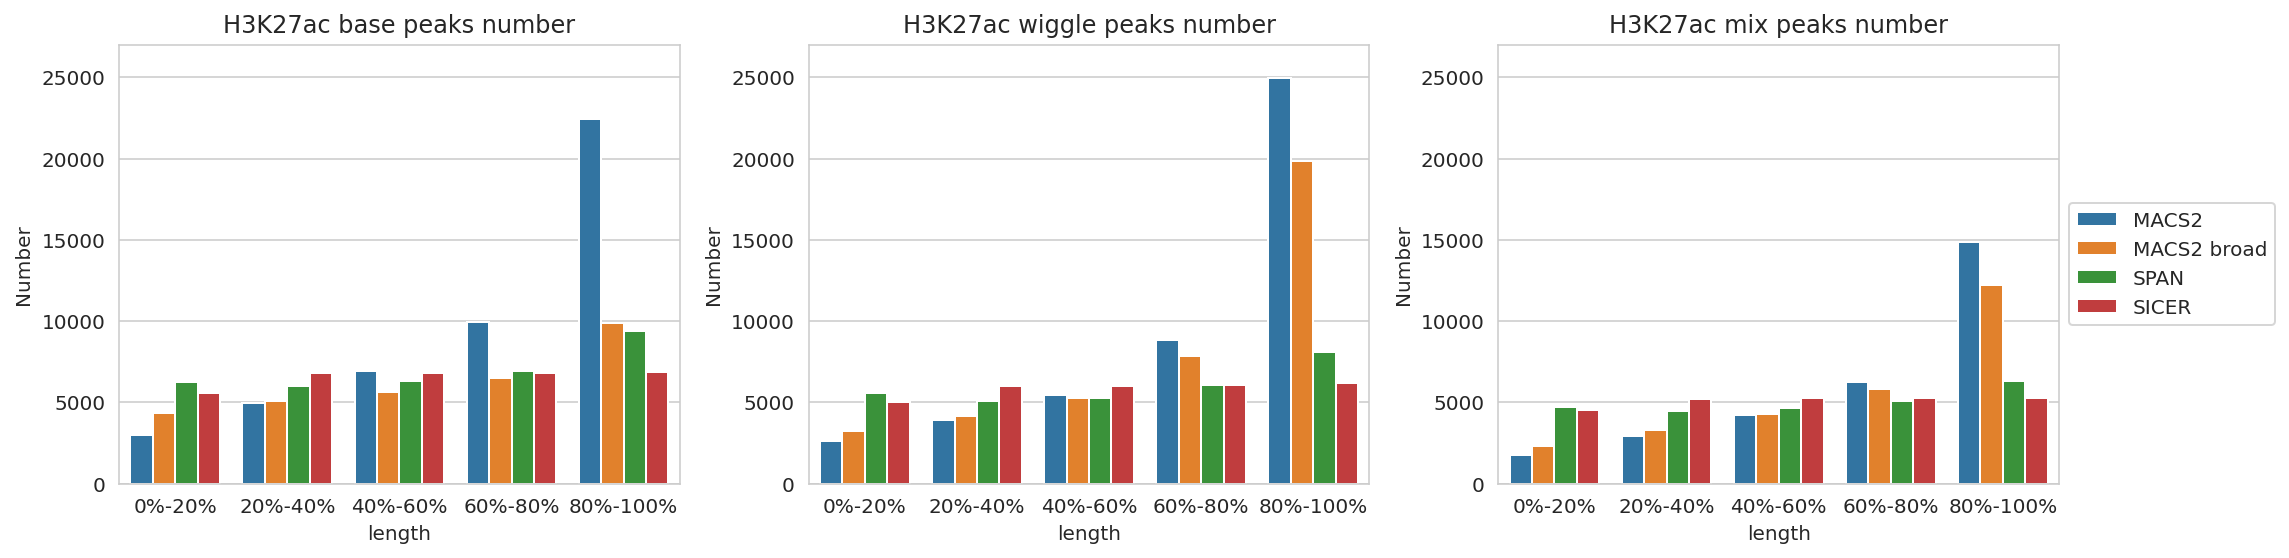

In [571]:
plt.figure(figsize=(16, 4))
axs = [plt.subplot(1, 3, i + 1) for i in range(3)]


for i, ty in enumerate(['base', 'wiggle', 'mix']):
    tf = tempfile.mktemp()

    print(ty)
    ax = axs[i]
    g_results = sns.barplot(data=perc_peaks_df[perc_peaks_df['type'] == ty],
                            y='peaks', x='length', ax=ax,
                            hue='tool',
                            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                            palette=TOOLS_PALETTE,
                            )
    ax.title.set_text(f'H3K27ac {ty} peaks number')
    g_results.axes.set_ylabel('Number')
    ax.set_ylim(0, 27_000)
    if i != 2:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_wiggle_mix_percentiles.pdf', bbox_inches='tight', dpi=300)
plt.show()

base
wiggle
mix


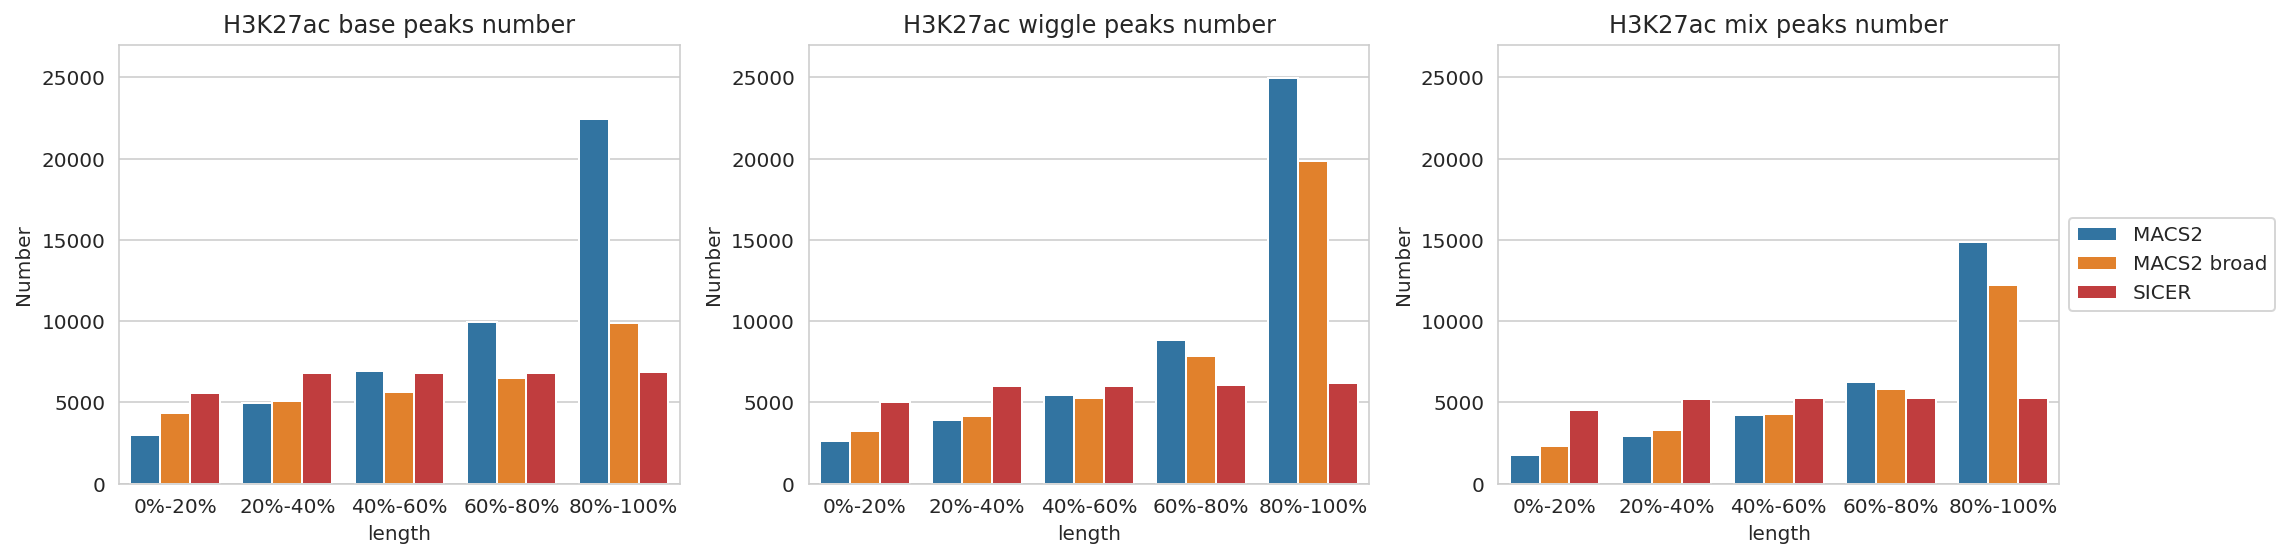

In [572]:
plt.figure(figsize=(16, 4))
axs = [plt.subplot(1, 3, i + 1) for i in range(3)]


for i, ty in enumerate(['base', 'wiggle', 'mix']):
    tf = tempfile.mktemp()

    print(ty)
    ax = axs[i]
    g_results = sns.barplot(data=perc_peaks_df[perc_peaks_df['type'] == ty],
                            y='peaks', x='length', ax=ax,
                            hue='tool',
                            hue_order=['MACS2', 'MACS2 broad', 'SICER'],
                            palette=TOOLS_PALETTE,
                            )
    ax.title.set_text(f'H3K27ac {ty} peaks number')
    g_results.axes.set_ylabel('Number')
    ax.set_ylim(0, 27_000)
    if i != 2:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_wiggle_mix_percentiles_no_span.pdf', bbox_inches='tight', dpi=300)
plt.show()

base
wiggle
mix


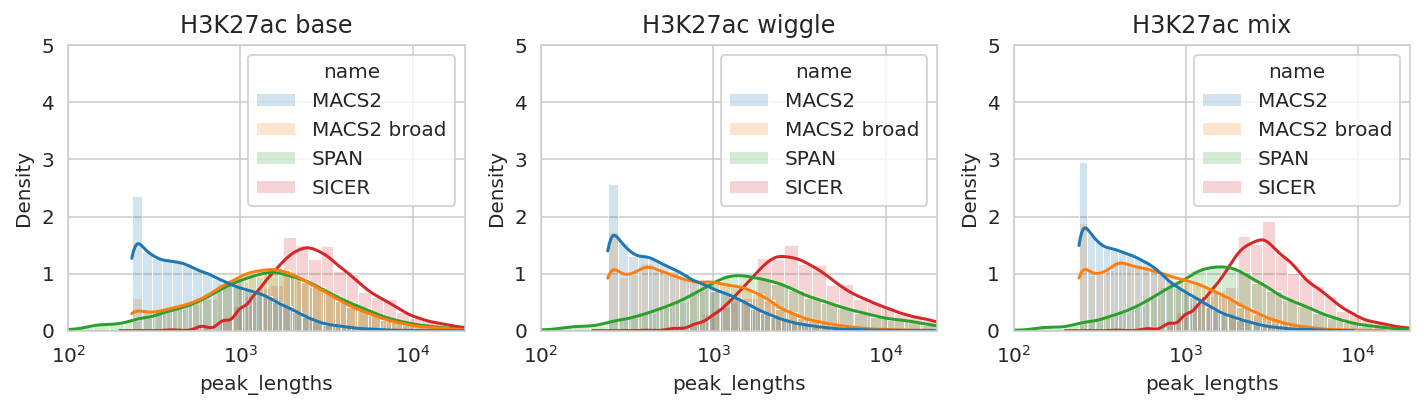

In [581]:
plt.figure(figsize=(10, 3))
axs = [plt.subplot(1, 3, i + 1) for i in range(3)]

for i, ty in enumerate(['base', 'wiggle', 'mix']):
    tf = tempfile.mktemp()
    print(ty)
    ax = axs[i]
    g_results = sns.histplot(data=perc_len_df[perc_len_df['type'] == ty], x='peak_lengths', hue='name', ax=ax,
                             stat='density', common_bins=False, common_norm=False,
                             bins=35, kde=True, log_scale=True, alpha=0.2,
                             palette=TOOLS_PALETTE,
                             hue_order=TOOLS)
    g_results.set(xscale='log')
    g_results.set_ylim(0, 5)
    g_results.set_xlim(1e2, 2e4)
    ax.title.set_text(f'H3K27ac {ty}')

plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_wiggle_mix_lengths.pdf', bbox_inches='tight', dpi=300)
plt.show()

base
wiggle
mix


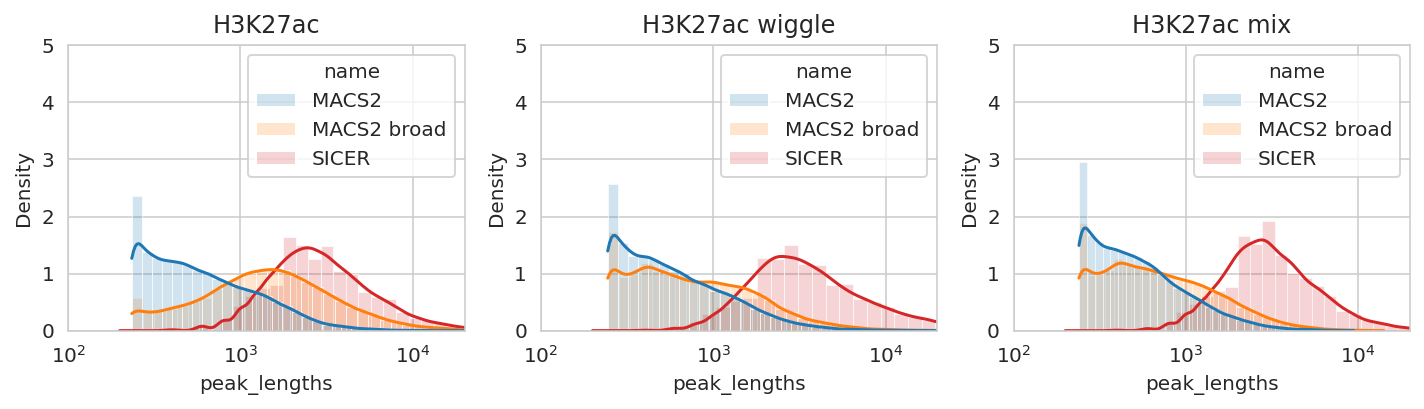

In [588]:
plt.figure(figsize=(10, 3))
axs = [plt.subplot(1, 3, i + 1) for i in range(3)]

for i, ty in enumerate(['base', 'wiggle', 'mix']):
    tf = tempfile.mktemp()
    print(ty)
    ax = axs[i]
    g_results = sns.histplot(data=perc_len_df[perc_len_df['type'] == ty], x='peak_lengths', hue='name', ax=ax,
                             stat='density', common_bins=False, common_norm=False,
                             bins=35, kde=True, log_scale=True, alpha=0.2,
                             palette=TOOLS_PALETTE,
                             hue_order=['MACS2', 'MACS2 broad', 'SICER'])
    g_results.set(xscale='log')
    g_results.set_ylim(0, 5)
    g_results.set_xlim(1e2, 2e4)
    if ty != 'base':
        ax.title.set_text(f'H3K27ac {ty}')
    else:
        ax.title.set_text('H3K27ac')

plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_wiggle_mix_lengths_nospan.pdf', bbox_inches='tight', dpi=300)
plt.show()

MACS2
MACS2 broad
SICER


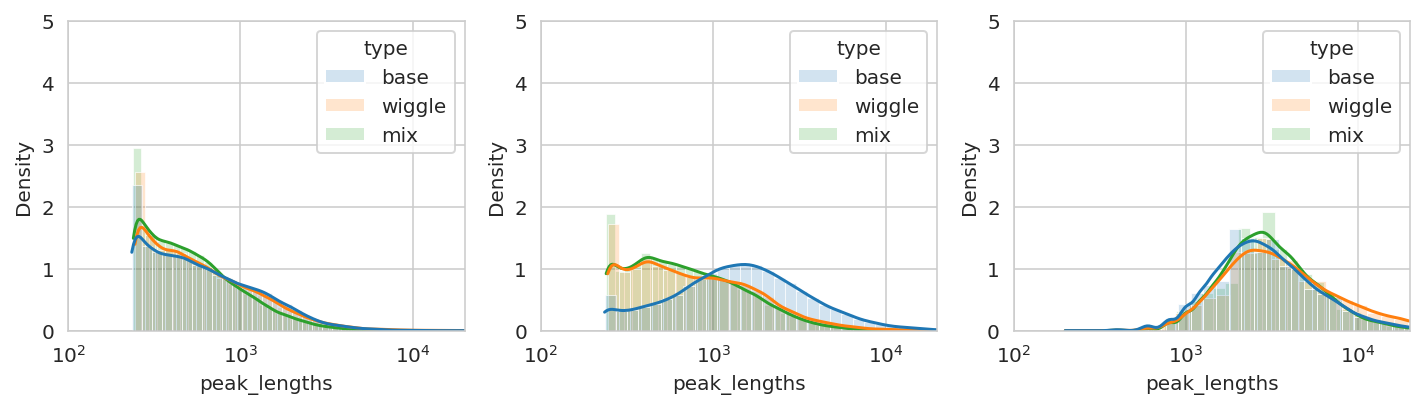

In [604]:
plt.figure(figsize=(10, 3))
axs = [plt.subplot(1, 3, i + 1) for i in range(3)]

for i, tool in enumerate(['MACS2', 'MACS2 broad', 'SICER']):
    tf = tempfile.mktemp()
    print(tool)
    ax = axs[i]
    g_results = sns.histplot(data=perc_len_df[perc_len_df['name'] == tool], x='peak_lengths', hue='type', ax=ax,
                             stat='density', common_bins=False, common_norm=False,
                             bins=35, kde=True, log_scale=True, alpha=0.2,
                             hue_order=['base', 'wiggle', 'mix']
                             )
    g_results.set(xscale='log')
    g_results.set_ylim(0, 5)
    g_results.set_xlim(1e2, 2e4)

plt.tight_layout()
plt.show()

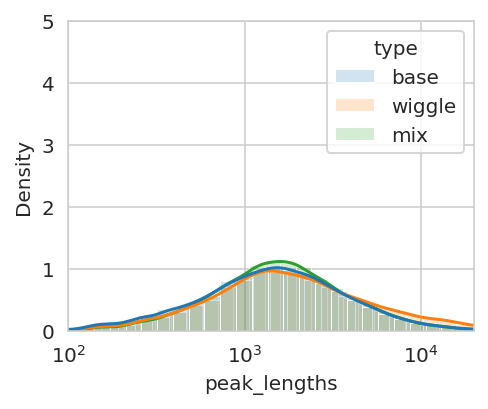

In [593]:
plt.figure(figsize=(3.5, 3))

ax = plt.axes()
g_results = sns.histplot(data=perc_len_df[perc_len_df['name'] == 'SPAN'], x='peak_lengths', hue='type', ax=ax,
                             stat='density', common_bins=False, common_norm=False,
                             bins=35, kde=True, log_scale=True, alpha=0.2,
                             # palette=TOOLS_PALETTE,
                             # hue_order=['MACS2', 'MACS2 broad', 'SICER']
                             )
g_results.set(xscale='log')
g_results.set_ylim(0, 5)
g_results.set_xlim(1e2, 2e4)

plt.tight_layout()
plt.show()

# Estimate Coverage variance in mix / wiggle regions

In [575]:
from math import ceil
import pyBigWig

RD = os.path.expanduser('~/data/2023_Immune')
bed_encode = os.path.expanduser('~/data/2023_GSE26320/union/H3K27ac_GM12878_rep1.bed')
bed_roadmap = os.path.expanduser('~/data/2023_Immune/union/H3K27ac_TCell.bed')
data = [
    ('wiggle', f'{WD}/bw/GSM646316_GM12878_H3K27ac_rep1_wiggle.bw', bed_encode),
    ('mix', f'{WD}/bw/GSM646316_GM12878_H3K27ac_rep1_mix.bw', bed_encode),
    ('ENCODE', f'{os.path.expanduser("~/data/2023_GSE26320/bw/GSM646316_GM12878_H3K27ac_rep1.bw")}', bed_encode),
    ('Roadmap', f'{RD}/bw/TCell_H3K27ac_hg38_ENCFF530DQB.bw', bed_roadmap)
]

variances = []
bin = 100
for name, bwf, percf in data:
    print(name, bwf, percf)
    t = pd.read_csv(percf, sep='\t', header=None)
    with pyBigWig.open(bwf) as bw:
        # Resort top scored peaks by density and start with the most dense ones
        total_coverage = sum(bw.stats(chr, exact=True, type='sum')[0] for chr in CHROM_SIZES.keys() if '_' not in chr) / 1e6
        print('Total coverage', total_coverage)
        for chr, start, end in tqdm(zip(t[0], t[1], t[2])):
            if chr in CHROM_SIZES:
                # Normalize by total coverage
                stats = [c / total_coverage for c in bw.stats(chr, start, end, nBins=int(ceil((end - start) / bin)), exact=True)]
                variances.append((name, f'{chr}:{start}-{end}', np.var(stats))) 
            
df_vars = pd.DataFrame(variances, columns=['name', 'position', 'variance'])
del variances
df_vars.sample(5)

wiggle /home/jetbrains/data/2023_GSE26320_wiggle_mix/bw/GSM646316_GM12878_H3K27ac_rep1_wiggle.bw /home/jetbrains/data/2023_GSE26320/union/H3K27ac_GM12878_rep1.bed
Total coverage 97.17621777542877


0it [00:00, ?it/s]

mix /home/jetbrains/data/2023_GSE26320_wiggle_mix/bw/GSM646316_GM12878_H3K27ac_rep1_mix.bw /home/jetbrains/data/2023_GSE26320/union/H3K27ac_GM12878_rep1.bed
Total coverage 98.46488338034725


0it [00:00, ?it/s]

ENCODE /home/jetbrains/data/2023_GSE26320/bw/GSM646316_GM12878_H3K27ac_rep1.bw /home/jetbrains/data/2023_GSE26320/union/H3K27ac_GM12878_rep1.bed
Total coverage 95.99449994272328


0it [00:00, ?it/s]

Roadmap /home/jetbrains/data/2023_Immune/bw/TCell_H3K27ac_hg38_ENCFF530DQB.bw /home/jetbrains/data/2023_Immune/union/H3K27ac_TCell.bed
Total coverage 84.9097751298113


0it [00:00, ?it/s]

,name,position,variance
88655,ENCODE,chr22:22720200-22722399,1.065080e-05
66612,mix,chr9:106980800-106982399,8.354895e-07
123461,Roadmap,chr4:15649200-15657599,2.020834e-05
111472,Roadmap,chr15:22757200-22759199,6.767222e-07
95635,ENCODE,chr6:44237200-44238199,9.039905e-06


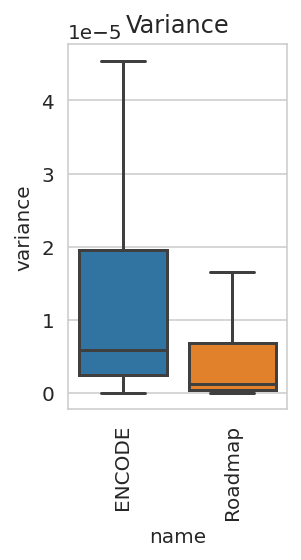

In [576]:
plt.figure(figsize=(2.2, 4))
ax = plt.axes()
g_results = sns.boxplot(data=df_vars[(df_vars['name'] == 'ENCODE') | (df_vars['name'] == 'Roadmap')], x='name', y='variance', showfliers=False)
ax.xaxis.set_tick_params(rotation=90)
# ax.title.set_text('Variance in 80%-100%')
ax.title.set_text('Variance')
plt.tight_layout()
plt.show()

In [577]:
from scipy.stats import mannwhitneyu
from scipy import stats

encode_vars = df_vars[df_vars['name'] == 'ENCODE']['variance'].values
roadmap_vars = df_vars[df_vars['name'] == 'Roadmap']['variance'].values

print('ENCODE Roamdap MannwhitneyU', mannwhitneyu(encode_vars, roadmap_vars))
print('ENCODE Roamdap Ttest', stats.ttest_ind(encode_vars, roadmap_vars))

ENCODE Roamdap MannwhitneyU MannwhitneyuResult(statistic=747737663.0, pvalue=0.0)
ENCODE Roamdap Ttest Ttest_indResult(statistic=39.037867901240595, pvalue=0.0)


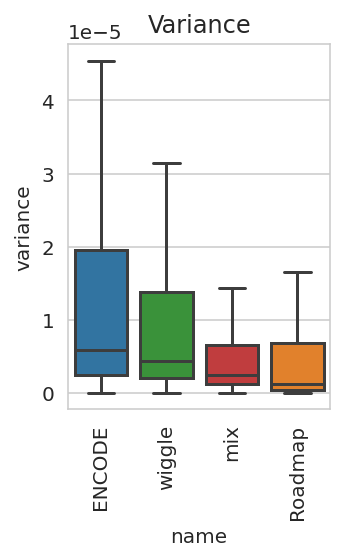

In [584]:
MODS = ['ENCODE', 'Roadmap', 'wiggle', 'mix']
palette = plt.cm.get_cmap('tab10')
MODS_PALETTE = {t: palette(i) for i, t in enumerate(MODS)}

plt.figure(figsize=(2.5, 4))
ax = plt.axes()
g_results = sns.boxplot(data=df_vars, x='name', y='variance', showfliers=False,
                        order=['ENCODE', 'wiggle', 'mix', 'Roadmap'],
                        palette=MODS_PALETTE)
ax.xaxis.set_tick_params(rotation=90)
# ax.title.set_text('Variance in 80%-100%')
ax.title.set_text('Variance')
plt.tight_layout()
plt.show()

In [579]:
from scipy.stats import mannwhitneyu
from scipy import stats

wiggle_vars = df_vars[df_vars['name'] == 'wiggle']['variance'].values
mix_vars = df_vars[df_vars['name'] == 'mix']['variance'].values

print('Roadmap wiggle MannwhitneyU', mannwhitneyu(roadmap_vars, wiggle_vars))
print('Roadmap wiggle Ttest', stats.ttest_ind(roadmap_vars, wiggle_vars))

print('Roadmap wiggle MannwhitneyU', mannwhitneyu(roadmap_vars, mix_vars))
print('Roadmap wiggle Ttest', stats.ttest_ind(roadmap_vars, mix_vars))

Roadmap wiggle MannwhitneyU MannwhitneyuResult(statistic=308555678.0, pvalue=0.0)
Roadmap wiggle Ttest Ttest_indResult(statistic=-18.738119498245414, pvalue=3.917758942279339e-78)
Roadmap wiggle MannwhitneyU MannwhitneyuResult(statistic=389920657.0, pvalue=0.0)
Roadmap wiggle Ttest Ttest_indResult(statistic=24.78369277278946, pvalue=5.824149294746485e-135)


# Compare Jaccard between MACS2 broad and SPAN

## GM12878

In [84]:
reps = {
    'MACS2 broad': [f'{GSE26320_PATH_HG38}/macs2/GSM646316_GM12878_H3K27ac_rep1_broad0.1_peaks.broadPeak',
                    f'{GSE26320_PATH_HG38}/macs2/GSM646317_GM12878_H3K27ac_rep2_broad0.1_peaks.broadPeak'],
    'SPAN': [f'{GSE26320_PATH_HG38}/span/GSM646316_GM12878_H3K27ac_rep1_100_0.05_3.peak',
             f'{GSE26320_PATH_HG38}/span/GSM646317_GM12878_H3K27ac_rep2_100_0.05_3.peak']
}
print('SPAN r1', lines(reps['SPAN'][0]), bedl(reps['SPAN'][0]).sum())
print('SPAN r2', lines(reps['SPAN'][1]), bedl(reps['SPAN'][1]).sum())

SPAN r1 34842 78383419
SPAN r2 31050 70478499


In [85]:
import tempfile

perc_reps_overlap = pd.DataFrame(
    columns=['tool', 'length_percentage',
             'peaks1', 'peaks1_len', 'peaks2', 'peaks2_len',
             'peaks1_overlap', 'peaks1_overlap_len',
             'peaks2_overlap', 'peaks2_overlap_len'], dtype=object)

dfso = []
dfsl = []
for tool, (rep1, rep2) in reps.items():
    tf = tempfile.mktemp()
    # This prints only overlapping A and B features, skipping non-overlapping
    !bedtools intersect -a {sorted_file(rep1)} -b {sorted_file(rep2)} -wo > {tf}
    t = pd.read_csv(tf, sep='\t', header=None)
    tl = pd.DataFrame(dict(diff=pd.concat([t[10] - t[1], t[11] - t[2]]).reset_index(drop=True), 
                           overlap=pd.concat([t[18], t[18]]).reset_index(drop=True)))
    tl['name'] = tool
    dfsl.append(tl)
    
tl = pd.concat(dfsl).reset_index(drop=True)
display(tl.sample(3))

,diff,overlap,name
6981,73,732,MACS2 broad
424,-618,440,MACS2 broad
72758,170,5697,SPAN


In [86]:
tl['abs_diff'] = np.fabs(tl['diff']) + 1
tl = tl[(tl['overlap'] < 10_000) & (tl['abs_diff'] < 10_000)]

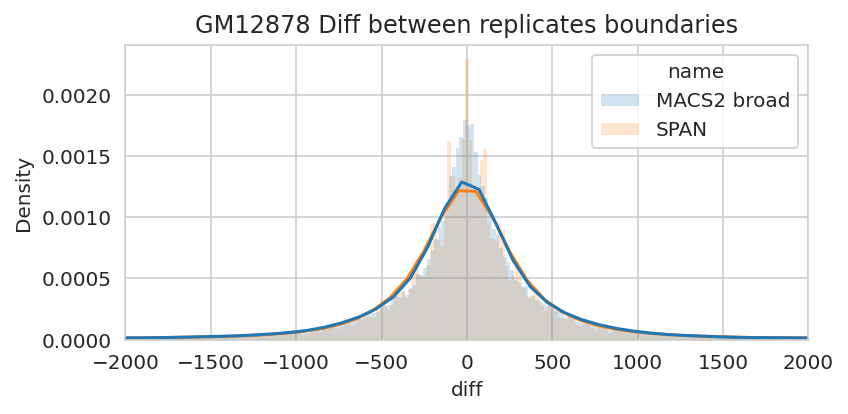

In [87]:
plt.figure(figsize=(6, 3))
g_results = sns.histplot(data=tl, x='diff', hue='name',
                         stat='density', common_bins=False, common_norm=False,
                         kde=True, alpha=0.2)
g_results.set_xlim(-2_000, 2_000)
g_results.axes.title.set_text(f'GM12878 Diff between replicates boundaries')

plt.tight_layout()
plt.show()

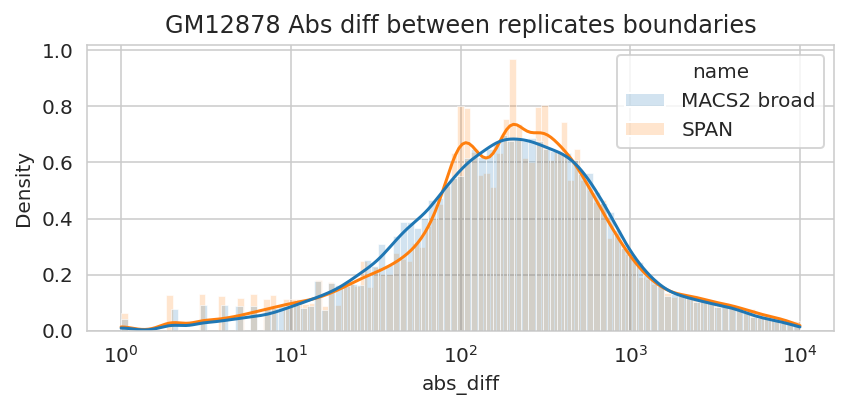

In [88]:
plt.figure(figsize=(6, 3))
g_results = sns.histplot(data=tl, x='abs_diff', hue='name',
                         stat='density', common_bins=False, common_norm=False,
                         kde=True, log_scale=True, alpha=0.2)
g_results.set(xscale='log')
g_results.axes.title.set_text(f'GM12878 Abs diff between replicates boundaries')

plt.tight_layout()
plt.show()

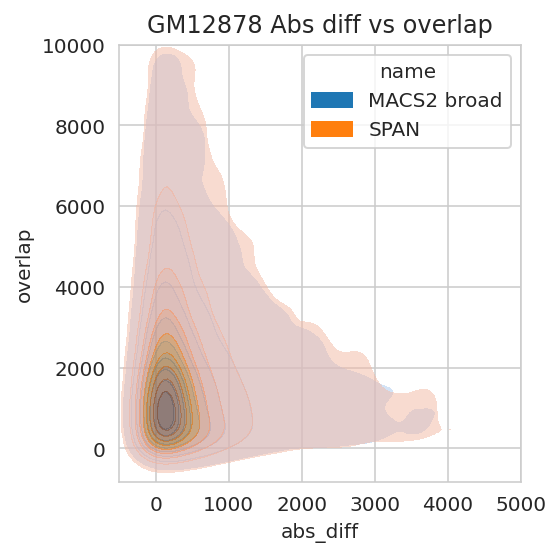

In [89]:
plt.figure(figsize=(4, 4))
g_results = sns.kdeplot(data=tl, x='abs_diff', y='overlap', hue='name', fill=True, alpha=0.5)
g_results.set_xlim(xmax=5_000)
g_results.set_ylim(ymax=10_000)
g_results.axes.title.set_text(f'GM12878 Abs diff vs overlap')
plt.tight_layout()
plt.show()

## HSMM

In [91]:
reps = {
    'MACS2 broad': [f'{GSE26320_PATH_HG38}/macs2/GSM646394_HSMM_H3K27ac_rep1_broad0.1_peaks.broadPeak',
                    f'{GSE26320_PATH_HG38}/macs2/GSM646395_HSMM_H3K27ac_rep2_broad0.1_peaks.broadPeak'],
    'SPAN': [f'{GSE26320_PATH_HG38}/span/GSM646394_HSMM_H3K27ac_rep1_100_0.05_3.peak',
             f'{GSE26320_PATH_HG38}/span/GSM646395_HSMM_H3K27ac_rep2_100_0.05_3.peak']
}
print('SPAN r1', lines(reps['SPAN'][0]), bedl(reps['SPAN'][0]).sum())
print('SPAN r2', lines(reps['SPAN'][1]), bedl(reps['SPAN'][1]).sum())

HSMM cell line
SPAN r1 38858 60035458
SPAN r2 49653 75247739


In [92]:
import tempfile

perc_reps_overlap = pd.DataFrame(
    columns=['tool', 'length_percentage',
             'peaks1', 'peaks1_len', 'peaks2', 'peaks2_len',
             'peaks1_overlap', 'peaks1_overlap_len',
             'peaks2_overlap', 'peaks2_overlap_len'], dtype=object)

dfso = []
dfsl = []
for tool, (rep1, rep2) in reps.items():
    tf = tempfile.mktemp()
    # This prints only overlapping A and B features, skipping non-overlapping
    !bedtools intersect -a {sorted_file(rep1)} -b {sorted_file(rep2)} -wo > {tf}
    t = pd.read_csv(tf, sep='\t', header=None)
    tl = pd.DataFrame(dict(diff=pd.concat([t[10] - t[1], t[11] - t[2]]).reset_index(drop=True),
                           overlap=pd.concat([t[18], t[18]]).reset_index(drop=True)))
    tl['name'] = tool
    dfsl.append(tl)

tl = pd.concat(dfsl).reset_index(drop=True)
display(tl.sample(3))

,diff,overlap,name
55709,-279,1348,MACS2 broad
67557,-430,934,MACS2 broad
90163,79,1154,SPAN


In [93]:
tl['abs_diff'] = np.fabs(tl['diff']) + 1
tl = tl[(tl['overlap'] < 10_000) & (tl['abs_diff'] < 10_000)]

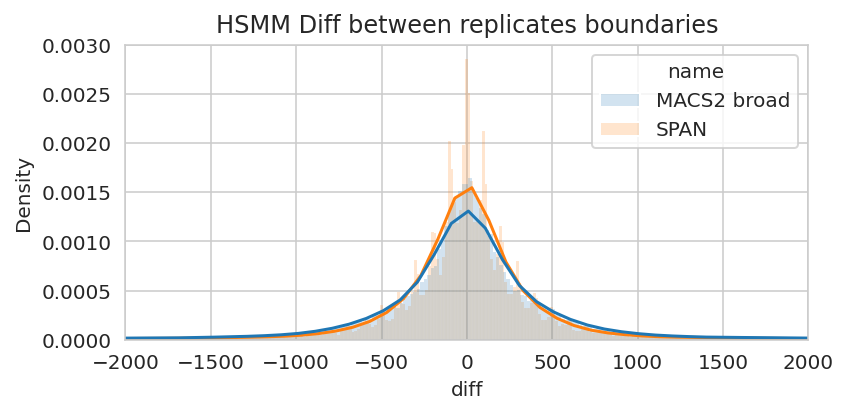

In [94]:
plt.figure(figsize=(6, 3))
g_results = sns.histplot(data=tl, x='diff', hue='name',
                         stat='density', common_bins=False, common_norm=False,
                         kde=True, alpha=0.2)
g_results.set_xlim(-2_000, 2_000)
g_results.axes.title.set_text(f'HSMM Diff between replicates boundaries')

plt.tight_layout()
plt.show()

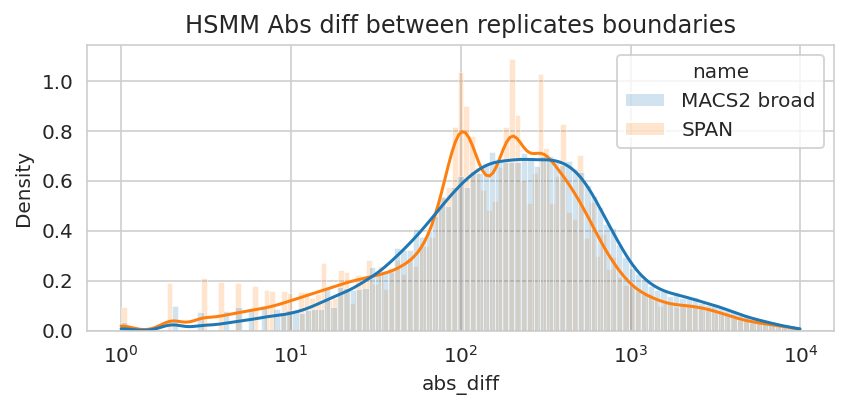

In [95]:
plt.figure(figsize=(6, 3))
g_results = sns.histplot(data=tl, x='abs_diff', hue='name',
                         stat='density', common_bins=False, common_norm=False,
                         kde=True, log_scale=True, alpha=0.2)
g_results.set(xscale='log')
g_results.axes.title.set_text(f'HSMM Abs diff between replicates boundaries')

plt.tight_layout()
plt.show()

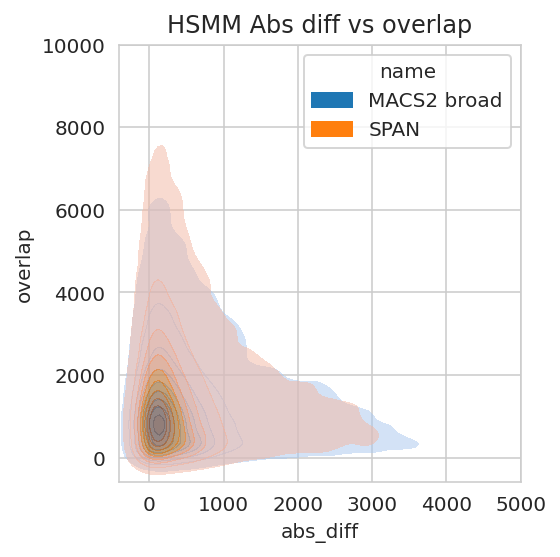

In [96]:
plt.figure(figsize=(4, 4))
g_results = sns.kdeplot(data=tl, x='abs_diff', y='overlap', hue='name', fill=True, alpha=0.5)
g_results.set_xlim(xmax=5_000)
g_results.set_ylim(ymax=10_000)
g_results.axes.title.set_text(f'HSMM Abs diff vs overlap')
plt.tight_layout()
plt.show()

## HMEC

In [99]:
reps = {
    'MACS2 broad': [f'{GSE26320_PATH_HG38}/macs2/GSM646374_HMEC_H3K27ac_rep1_broad0.1_peaks.broadPeak',
                    f'{GSE26320_PATH_HG38}/macs2/GSM646375_HMEC_H3K27ac_rep2_broad0.1_peaks.broadPeak'],
    'SPAN': [f'{GSE26320_PATH_HG38}/span/GSM646374_HMEC_H3K27ac_rep1_100_0.05_3.peak',
             f'{GSE26320_PATH_HG38}/span/GSM646375_HMEC_H3K27ac_rep2_100_0.05_3.peak']
}
print('SPAN r1', lines(reps['SPAN'][0]), bedl(reps['SPAN'][0]).sum())
print('SPAN r2', lines(reps['SPAN'][1]), bedl(reps['SPAN'][1]).sum())

SPAN r1 47858 82240423
SPAN r2 30534 51621487


In [100]:
import tempfile

perc_reps_overlap = pd.DataFrame(
    columns=['tool', 'length_percentage',
             'peaks1', 'peaks1_len', 'peaks2', 'peaks2_len',
             'peaks1_overlap', 'peaks1_overlap_len',
             'peaks2_overlap', 'peaks2_overlap_len'], dtype=object)

dfso = []
dfsl = []
for tool, (rep1, rep2) in reps.items():
    tf = tempfile.mktemp()
    # This prints only overlapping A and B features, skipping non-overlapping
    !bedtools intersect -a {sorted_file(rep1)} -b {sorted_file(rep2)} -wo > {tf}
    t = pd.read_csv(tf, sep='\t', header=None)
    tl = pd.DataFrame(dict(diff=pd.concat([t[10] - t[1], t[11] - t[2]]).reset_index(drop=True),
                           overlap=pd.concat([t[18], t[18]]).reset_index(drop=True)))
    tl['name'] = tool
    dfsl.append(tl)

tl = pd.concat(dfsl).reset_index(drop=True)
display(tl.sample(3))

,diff,overlap,name
52787,945,462,MACS2 broad
17830,-905,1307,MACS2 broad
50783,378,630,MACS2 broad


In [101]:
tl['abs_diff'] = np.fabs(tl['diff']) + 1
tl = tl[(tl['overlap'] < 10_000) & (tl['abs_diff'] < 10_000)]

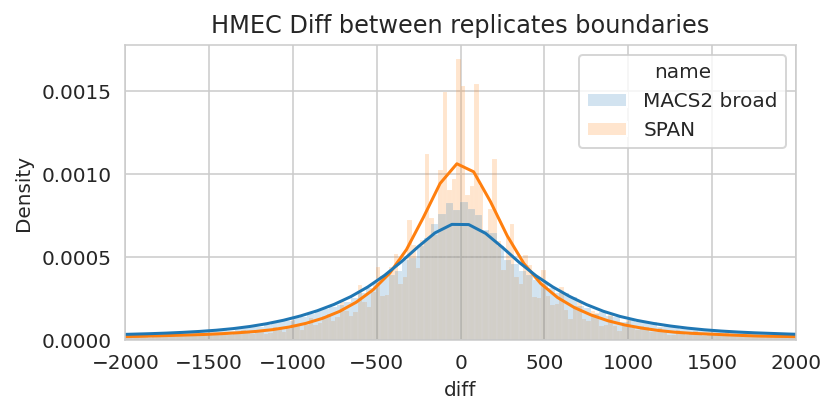

In [103]:
plt.figure(figsize=(6, 3))
g_results = sns.histplot(data=tl, x='diff', hue='name',
                         stat='density', common_bins=False, common_norm=False,
                         kde=True, alpha=0.2)
g_results.set_xlim(-2_000, 2_000)
g_results.axes.title.set_text(f'HMEC Diff between replicates boundaries')

plt.tight_layout()
plt.show()

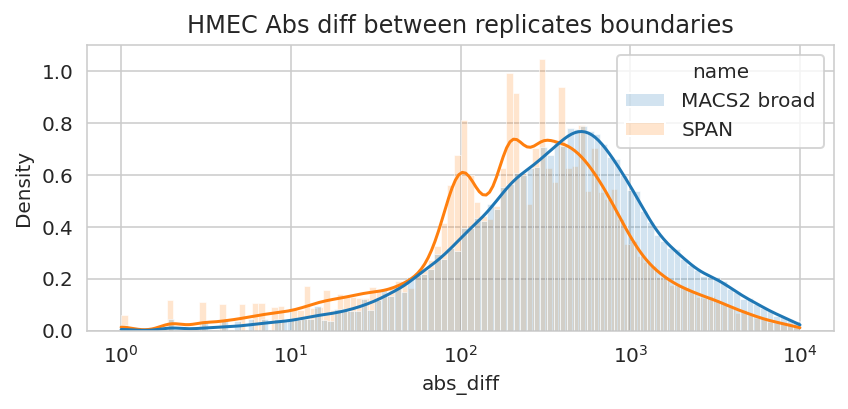

In [104]:
plt.figure(figsize=(6, 3))
g_results = sns.histplot(data=tl, x='abs_diff', hue='name',
                         stat='density', common_bins=False, common_norm=False,
                         kde=True, log_scale=True, alpha=0.2)
g_results.set(xscale='log')
g_results.axes.title.set_text(f'HMEC Abs diff between replicates boundaries')

plt.tight_layout()
plt.show()

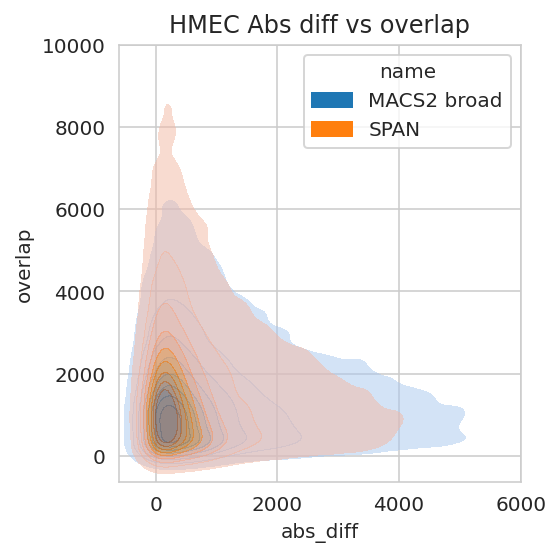

In [106]:
plt.figure(figsize=(4, 4))
g_results = sns.kdeplot(data=tl, x='abs_diff', y='overlap', hue='name', fill=True, alpha=0.5)
g_results.set_xlim(xmax=6_000)
g_results.set_ylim(ymax=10_000)
g_results.axes.title.set_text(f'HMEC Abs diff vs overlap')
plt.tight_layout()
plt.show()

# Compute "domains" by overlapping binned genome with peaks

```
for STEP in 1000 2000 5000 10000 20000; do
echo $STEP;

rm hg38_$STEP.bed

cat hg38.chrom.sizes | grep -v '_' | sort -k1,1 | while read -r L; do CHR=$(echo $L | awk '{print $1}'); SIZE=$(echo $L | awk '{print $2}'); echo "$CHR . . . $SIZE"; T=$'\t'; for I in $(seq 1 $STEP $SIZE); do J=$(($I+$STEP)); echo "$CHR$T$I$T$J" >> hg38_$STEP.bed; done; done

T1=$(mktemp);
T2=$(mktemp);

conda activate bio
for F in *Peak *peak *FDR0.01; do echo $F; rm $T1 $T2; cat $F | sort -k1,1 -k2,2n > $T1; bedtools intersect -a hg38_$STEP.bed -b $F -wa -u > $T2; bedtools merge -i $T2 > $F.5000; done

done;
```

In [488]:
BWD = os.path.expanduser('~/data/2023_GSE26320_Immune_k27ac')
BINS = [1000, 2000, 5000, 10000, 20000]
ts = []
for bin in BINS:
    print(bin)
    df_macs2 = load_peaks(BWD, f'.narrowPeak.{bin}', cells=['GM12878', 'BCell'], replicates=['rep1', ''])
    df_macs2['tool'] = 'MACS2'
    df_macs2['bin'] = bin
    print('MACS2', len(df_macs2))

    df_macs2broad = load_peaks(BWD, f'.broadPeak.{bin}', cells=['GM12878', 'BCell'], replicates=['rep1', ''])
    df_macs2broad['tool'] = 'MACS2 broad'
    df_macs2broad['bin'] = bin
    print('MACS2 broad', len(df_macs2broad))

    df_sicer = load_peaks(BWD, f'summary-FDR0.01.{bin}', cells=['GM12878', 'BCell'], replicates=['rep1', ''])
    df_sicer['tool'] = 'SICER'
    df_sicer['bin'] = bin
    print('SICER', len(df_sicer))

    df_span = load_peaks(BWD, f'.peak.{bin}', cells=['GM12878', 'BCell'], replicates=['rep1', ''])
    df_span['tool'] = 'SPAN'
    df_span['bin'] = bin
    print('SPAN', len(df_span))
    ts.extend([df_macs2, df_macs2broad, df_sicer, df_span])

df_bins = pd.concat(ts).reset_index(drop=True)
display(df_bins.sample(3))
del ts

1000


  0%|          | 0/54 [00:00<?, ?it/s]

MACS2 2


  0%|          | 0/54 [00:00<?, ?it/s]

MACS2 broad 2


  0%|          | 0/54 [00:00<?, ?it/s]

SICER 2


  0%|          | 0/54 [00:00<?, ?it/s]

SPAN 2
2000


  0%|          | 0/54 [00:00<?, ?it/s]

MACS2 2


  0%|          | 0/54 [00:00<?, ?it/s]

MACS2 broad 2


  0%|          | 0/54 [00:00<?, ?it/s]

SICER 2


  0%|          | 0/54 [00:00<?, ?it/s]

SPAN 2
5000


  0%|          | 0/54 [00:00<?, ?it/s]

MACS2 2


  0%|          | 0/54 [00:00<?, ?it/s]

MACS2 broad 2


  0%|          | 0/54 [00:00<?, ?it/s]

SICER 2


  0%|          | 0/54 [00:00<?, ?it/s]

SPAN 2
10000


  0%|          | 0/54 [00:00<?, ?it/s]

MACS2 2


  0%|          | 0/54 [00:00<?, ?it/s]

MACS2 broad 2


  0%|          | 0/54 [00:00<?, ?it/s]

SICER 2


  0%|          | 0/54 [00:00<?, ?it/s]

SPAN 2
20000


  0%|          | 0/54 [00:00<?, ?it/s]

MACS2 2


  0%|          | 0/54 [00:00<?, ?it/s]

MACS2 broad 2


  0%|          | 0/54 [00:00<?, ?it/s]

SICER 2


  0%|          | 0/54 [00:00<?, ?it/s]

SPAN 2


,file,modification,cell,replicate,peaks,avlength,tool,bin
29,/home/jetbrains/data/2023_GSE26320_Immune_k27a...,H3K27ac,GM12878,rep1,17168,21871.505126,SICER,10000
26,/home/jetbrains/data/2023_GSE26320_Immune_k27a...,H3K27ac,BCell,,15232,17744.879202,MACS2 broad,10000
5,/home/jetbrains/data/2023_GSE26320_Immune_k27a...,H3K27ac,GM12878,rep1,29658,5285.656484,SICER,1000


1000


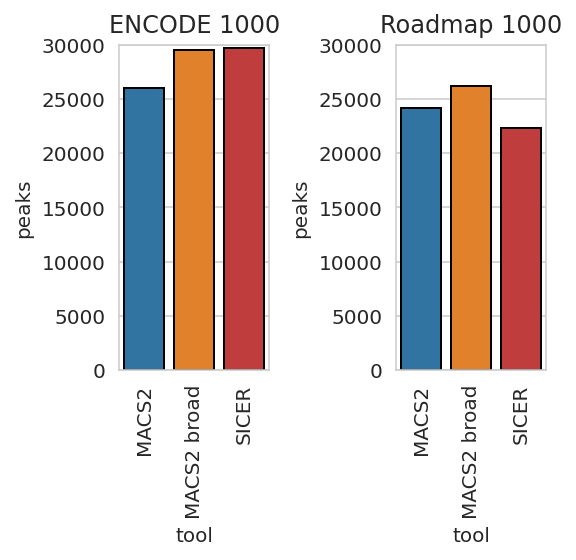

2000


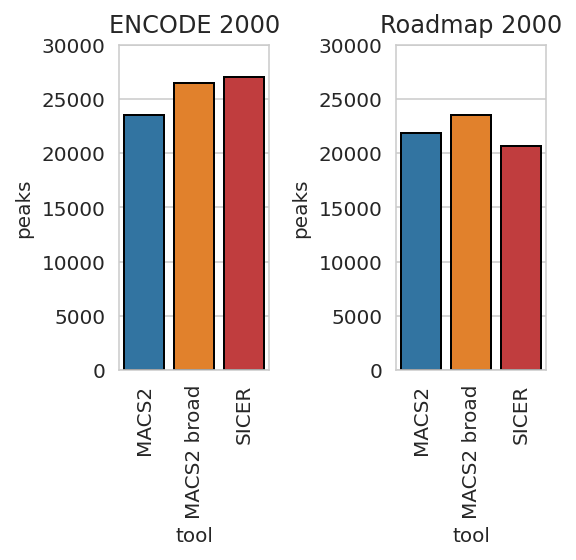

5000


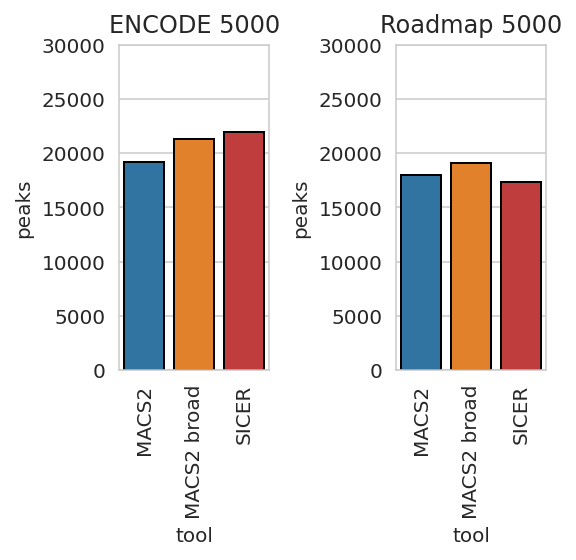

10000


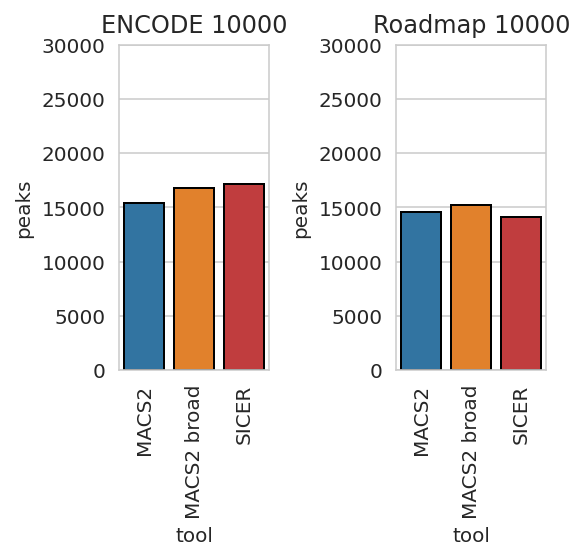

20000


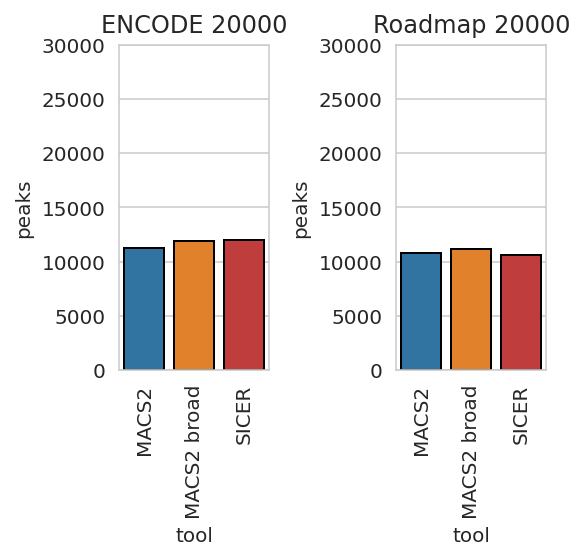

In [443]:
for bin in BINS:
    print(bin)
    plt.figure(figsize=(4, 4))
    axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
    ax = axs[0]
    g_results = sns.barplot(data=df_bins[(df_bins['bin']==bin) & (df_bins['cell']=='GM12878')], 
                            x='tool', y='peaks', ax=ax,
                        capsize=.2, errwidth=2, edgecolor="black",
                        palette=TOOLS_PALETTE,
                        order=['MACS2', 'MACS2 broad', 'SICER'])
    ax.xaxis.set_tick_params(rotation=90)
    ax.title.set_text('Peaks number')
    ax.set_ylim(0, 30_000)    
    ax.title.set_text(f'ENCODE {bin}')
    ax = axs[1]
    g_results = sns.barplot(data=df_bins[(df_bins['bin']==bin) & (df_bins['cell']=='BCell')],
                            x='tool', y='peaks', ax=ax,
                            capsize=.2, errwidth=2, edgecolor="black",
                            palette=TOOLS_PALETTE,
                            order=['MACS2', 'MACS2 broad', 'SICER'])
    ax.xaxis.set_tick_params(rotation=90)
    ax.title.set_text('Peaks number')
    ax.set_ylim(0, 30_000)
    ax.title.set_text(f'Roadmap {bin}')
    plt.tight_layout()
    plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_hg_{bin}_peaks_nospan.pdf', bbox_inches='tight', dpi=300)
    plt.show()

In [432]:
print('Load lengths')
ts = []
for cell, rep, file, tool, bin in tqdm(
        zip(df_bins['cell'], df_bins['replicate'], df_bins['file'], df_bins['tool'], df_bins['bin'])):
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t = t.sample(min(len(t), 10_000)).copy()
    t['cell'] = cell
    t['replicate'] = rep
    t['tool'] = tool
    t['bin'] = bin
    ts.append(t)
t = pd.concat(ts).reset_index(drop=True)
del ts
t.sample(10)

Load lengths


0it [00:00, ?it/s]

,length,cell,replicate,tool,bin
121715,6000,BCell,,SICER,2000
159581,6000,BCell,,SPAN,2000
251329,10000,BCell,,MACS2,10000
234434,5000,GM12878,rep1,SPAN,5000
87230,2000,BCell,,MACS2,2000
4706,2000,GM12878,rep1,MACS2,1000
324442,20000,BCell,,MACS2,20000
208994,5000,GM12878,rep1,SICER,5000
151921,4000,BCell,,SPAN,2000
295882,10000,GM12878,rep1,SICER,10000


1000


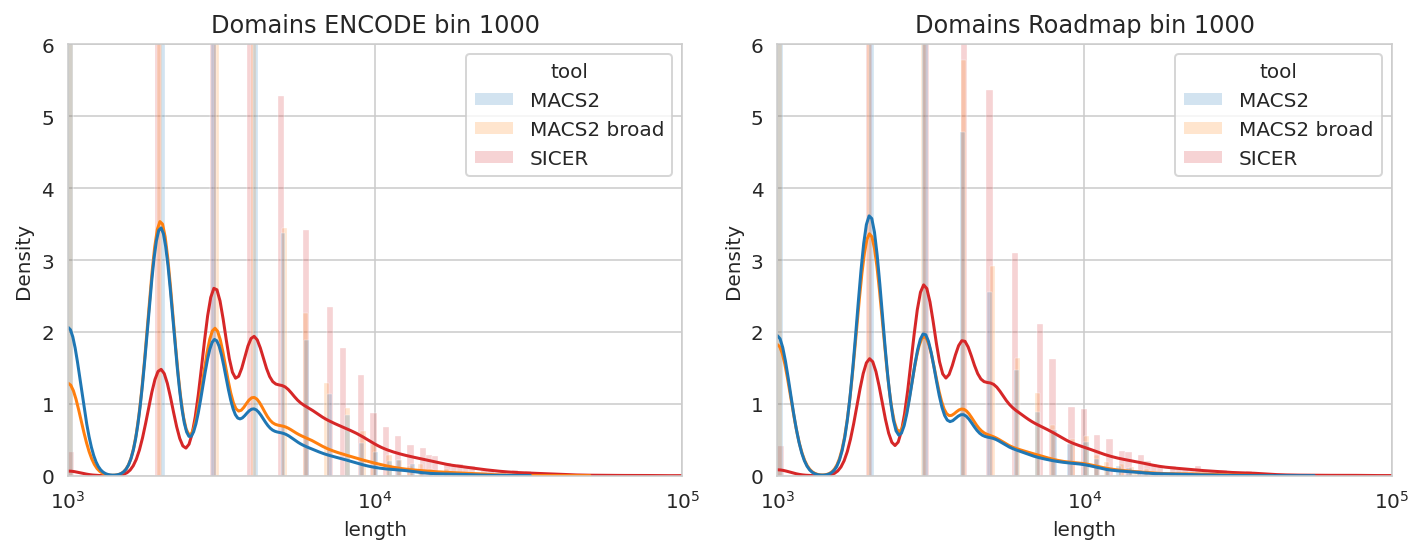

2000


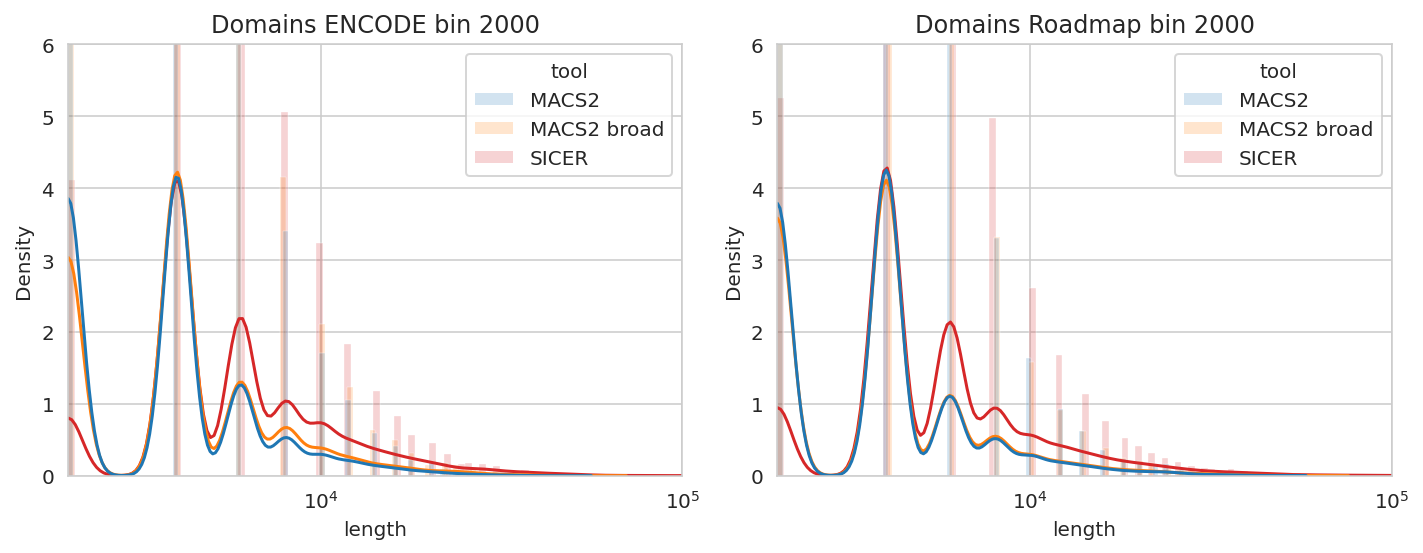

5000


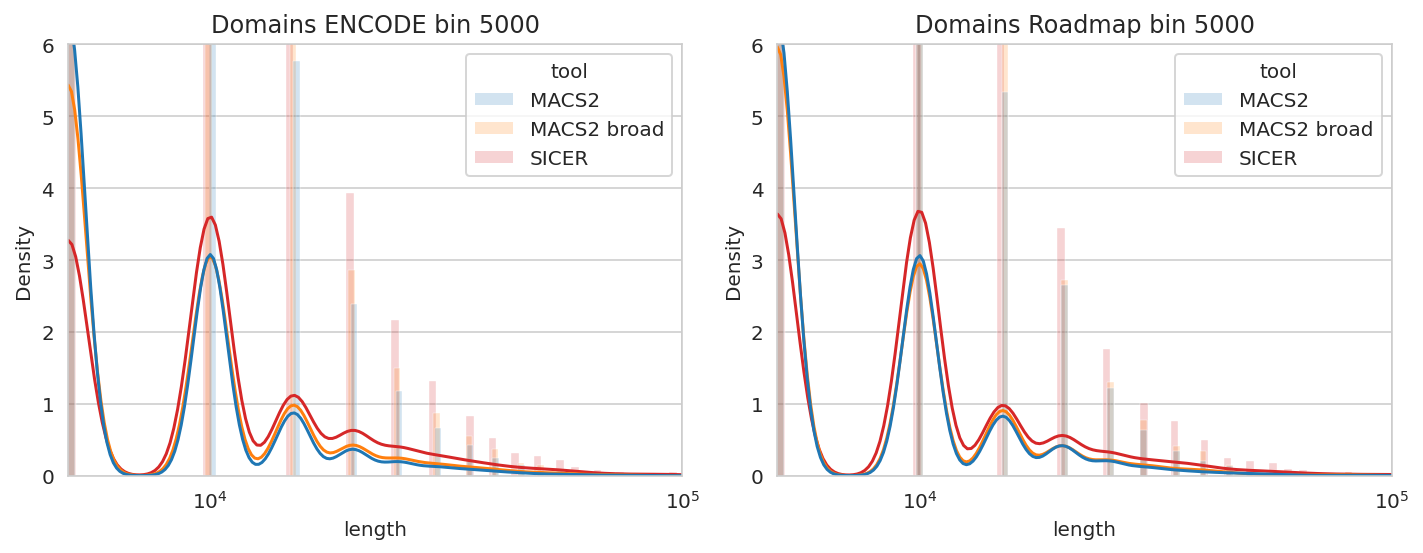

10000


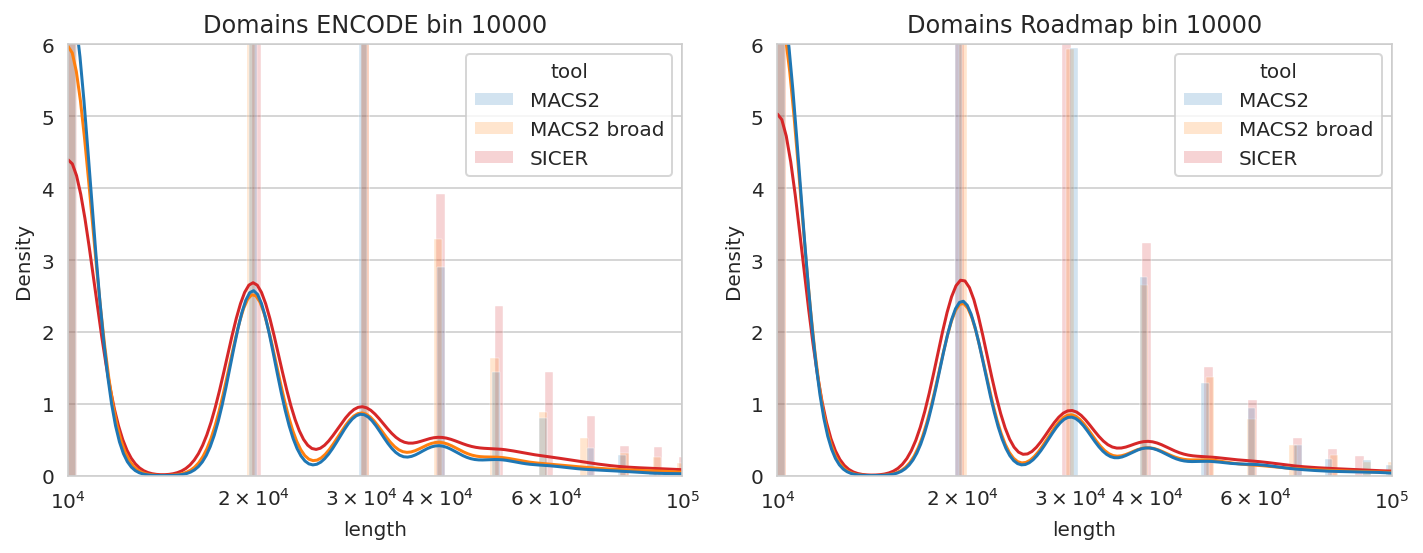

20000


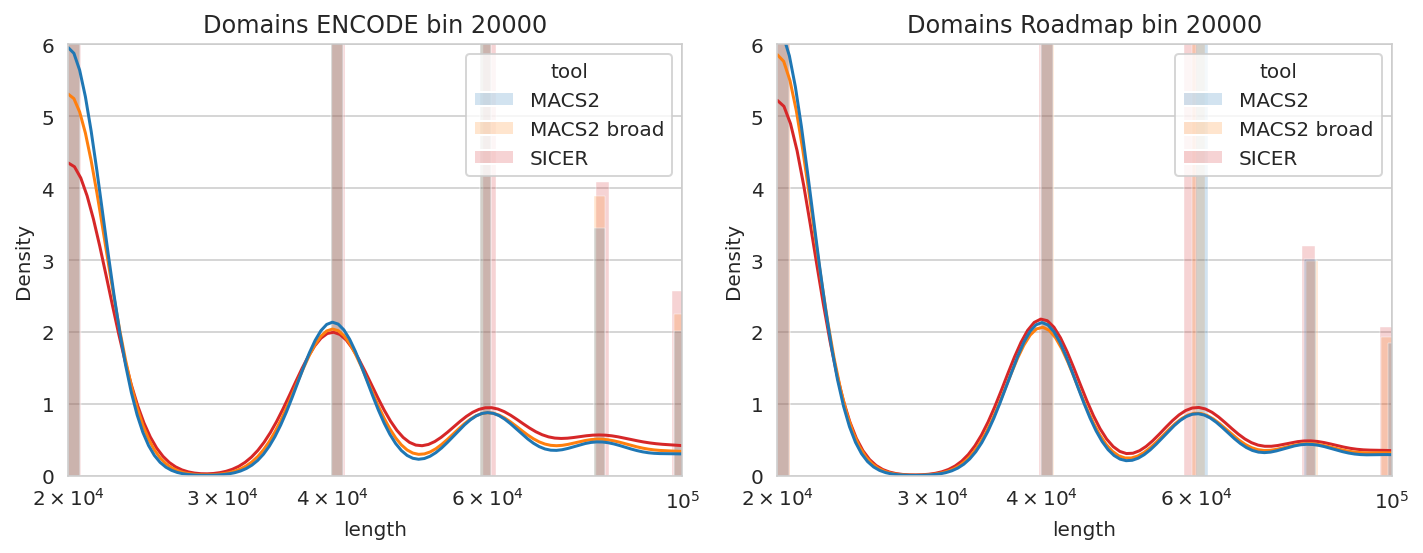

In [449]:
for bin in BINS:
    print(bin)
    plt.figure(figsize=(10, 4))
    axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
    ax = axs[0]
    g_results = sns.histplot(data=t[(t['bin']==bin) & (t['cell']=='GM12878')], 
                             x='length', hue='tool', ax=ax,
                             bins=100, stat='density', common_bins=False, common_norm=False,
                             kde=True, log_scale=True, alpha=0.2,
                             palette=TOOLS_PALETTE,
                             hue_order=['MACS2', 'MACS2 broad', 'SICER'])
    g_results.set(xscale='log')
    g_results.set_ylim(0, 6)
    g_results.set_xlim(bin, 1e5)
    ax.title.set_text(f'Domains ENCODE bin {bin}')
    ax = axs[1]
    g_results = sns.histplot(data=t[(t['bin']==bin) & (t['cell']=='BCell')], 
                             x='length', hue='tool', ax=ax,
                             bins=100, stat='density', common_bins=False, common_norm=False,
                             kde=True, log_scale=True, alpha=0.2,
                             palette=TOOLS_PALETTE,
                             hue_order=['MACS2', 'MACS2 broad', 'SICER'])
    g_results.set(xscale='log')
    g_results.set_ylim(0, 6)
    g_results.set_xlim(bin, 1e5)
    ax.title.set_text(f'Domains Roadmap bin {bin}')

    plt.tight_layout()
    plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_hg_{bin}_lengths_nospan.pdf', bbox_inches='tight', dpi=300)
    plt.show()

## Venn diagram

In [450]:
from matplotlib_venn import venn2, venn3

def num_format(x, engineer):
    if x <= 0:
        return ''
    elif engineer:
        return f'{x:.0e}'
    else:
        return str(x)

num_format(1.3e10, True)

VENN3_SUBSETS = ['1', '2', '1,2', '3', '1,3', '2,3', '1,2,3']
VENN3_LABELS = ['100', '010', '110', '001', '101', '011', '111']

def venn3_overlap(ax, v1, v2, v12, v3, v13, v23, v123, name1, name2, name3,
                  show_numbers=True, engineer=False,
                  set_font=15, subset_font=10):
    subsets=(v1, v2, v12, v3, v13, v23, v123)
    t = {l: s for l, s in zip(VENN3_LABELS, subsets)}
    v = venn3(subsets=subsets,
              set_labels=(name1, name2, name3),
              alpha=0.3,
              ax=ax)
    for text in v.set_labels:
        if text is not None:
            text.set_fontsize(set_font)
    for text in v.subset_labels:
        if text is not None:
            text.set_fontsize(subset_font)
    for l in VENN3_LABELS:
        label = v.get_label_by_id(l)
        if label is not None:
            if not show_numbers:
                label.set_text('')
            else:
                label.set_text(num_format(t[l], engineer))

In [494]:
IMMUNE_PATH = os.path.expanduser('~/data/2023_Immune')
# PATH = os.path.expanduser('~/data/2023_Immune_no_control')
IMMUNE_CELLS = ['BCell', 'TCell']
MODIFICATIONS = ['H3K27ac']

df_immune_macs2 = load_peaks(os.path.join(IMMUNE_PATH, 'macs2'), '.narrowPeak', 
                             cells=IMMUNE_CELLS, replicates=[''])
df_immune_macs2['tool'] = 'MACS2'
print('MACS2', len(df_immune_macs2))

df_immune_macs2broad = load_peaks(os.path.join(IMMUNE_PATH, 'macs2'), '.broadPeak', 
                                  cells=IMMUNE_CELLS, replicates=[''])
df_immune_macs2broad['tool'] = 'MACS2 broad'
print('MACS2 broad', len(df_immune_macs2broad))

df_immune_sicer = load_peaks(os.path.join(IMMUNE_PATH, 'sicer'), 'summary-FDR0.01', 
                             cells=IMMUNE_CELLS, replicates=[''])
# df_fdr_sicer = load_peaks_fdr(os.path.join(PATH, 'sicer'), 'scoreisland', ['0.01'])
df_immune_sicer['tool'] = 'SICER'
print('SICER', len(df_immune_sicer))

df_immune_span = load_peaks(os.path.join(IMMUNE_PATH, 'span'), '.peak', 
                            cells=IMMUNE_CELLS, replicates=[''])
df_immune_span['tool'] = 'SPAN'
print('SPAN', len(df_immune_span))

TOOLS = ['MACS2', 'MACS2 broad', 'SICER', 'SPAN']
df_immune_peaks = pd.concat(
    [df_immune_macs2, df_immune_macs2broad, df_immune_sicer, df_immune_span]
).reset_index(drop=True)
df_immune_peaks.sample(5)

  0%|          | 0/112 [00:00<?, ?it/s]

MACS2 2


  0%|          | 0/112 [00:00<?, ?it/s]

MACS2 broad 2


  0%|          | 0/118 [00:00<?, ?it/s]

SICER 2


  0%|          | 0/17 [00:00<?, ?it/s]

SPAN 2


,file,modification,cell,replicate,peaks,avlength,tool
5,/home/jetbrains/data/2023_Immune/sicer/BCell_H...,H3K27ac,BCell,,24342,3746.687125,SICER
4,/home/jetbrains/data/2023_Immune/sicer/TCell_H...,H3K27ac,TCell,,26338,4713.686005,SICER
0,/home/jetbrains/data/2023_Immune/macs2/TCell_H...,H3K27ac,TCell,,57350,960.794316,MACS2
6,/home/jetbrains/data/2023_Immune/span/TCell_H3...,H3K27ac,TCell,,31192,2721.691267,SPAN
7,/home/jetbrains/data/2023_Immune/span/BCell_H3...,H3K27ac,BCell,,26454,2055.782755,SPAN


GM12878 rep1 ENCODE


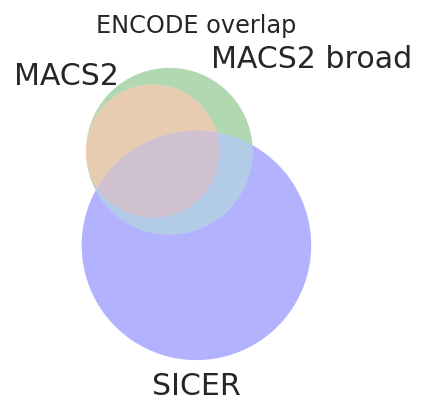

BCell  Roadmap


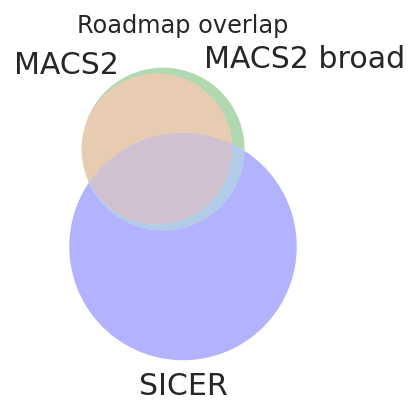

In [495]:
for cell, rep, name, df in [('GM12878', 'rep1', 'ENCODE', df_peaks), 
                            ('BCell', '', 'Roadmap', df_immune_peaks)]:
    print(cell, rep, name)
    
    macs2_file = df[(df['cell'] == cell) & (df['replicate'] == rep) & 
                    (df['tool'] == 'MACS2')]['file'].values[0]
    macs2_broad_file = df[(df['cell'] == cell) & (df['replicate'] == rep) & 
                          (df['tool'] == 'MACS2 broad')]['file'].values[0]
    sicer_file = df[(df['cell'] == cell) & (df['replicate'] == rep) & 
                    (df['tool'] == 'SICER')]['file'].values[0]

    tf = tempfile.mktemp()
    ! bedtools multiinter -i {macs2_file} {macs2_broad_file} {sicer_file} > {tf}
    t = pd.read_csv(tf, sep='\t', names=['chr', 'start', 'end',
                                         'overlap_number', 'overlap_details',
                                         'overlap1', 'overlap2', 'overlap3'])
    plt.figure(figsize=(3, 3))
    ax = plt.axes()
    venn3_overlap(ax, *[
        (t[t['overlap_details'] == o]['end'] - t[t['overlap_details'] == o]['start']).sum()
        # (t['overlap_details'] == o).sum() 
        for o in VENN3_SUBSETS
    ], 'MACS2', 'MACS2 broad', 'SICER', show_numbers=False, engineer=True)
    plt.title(f'{name} overlap')
    plt.tight_layout()
    plt.show()

GM12878 rep1 ENCODE
1000


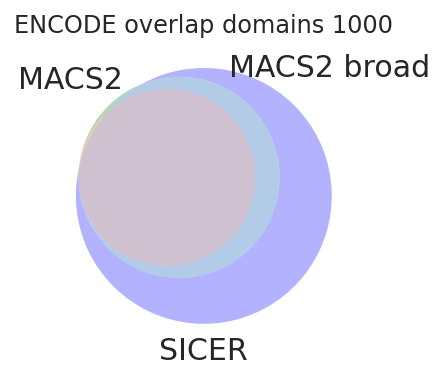

BCell  Roadmap
1000


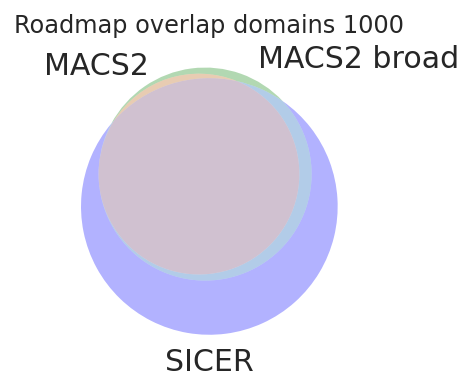

GM12878 rep1 ENCODE
5000


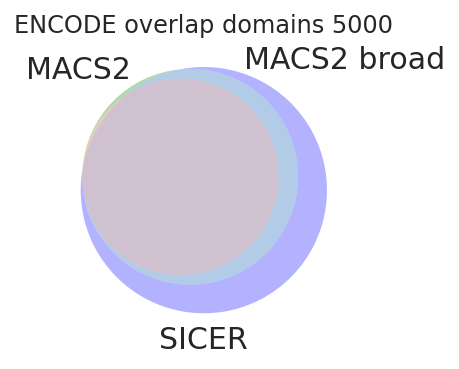

BCell  Roadmap
5000


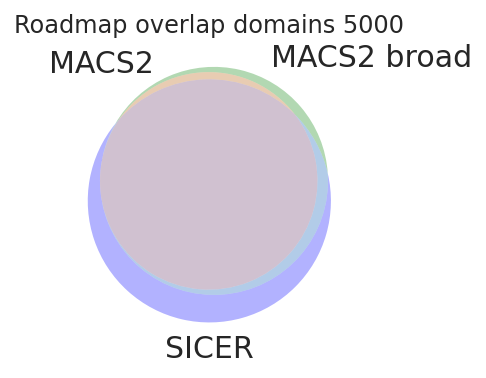

GM12878 rep1 ENCODE
20000


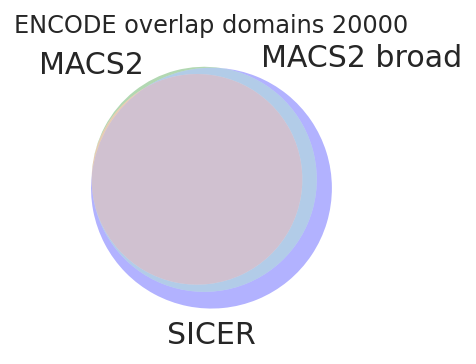

BCell  Roadmap
20000


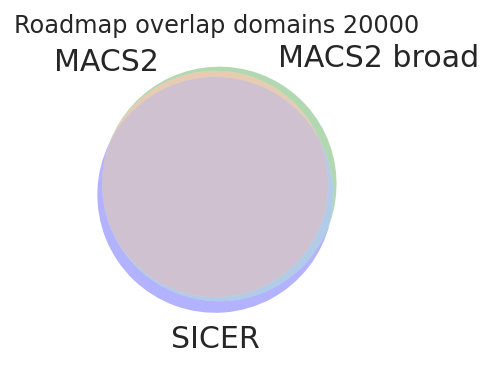

In [492]:
for bin in [1000, 5000, 20000]:
    for cell, rep, name in [('GM12878', 'rep1', 'ENCODE'),
                            ('BCell', '', 'Roadmap')]:
        print(cell, rep, name)    
        print(bin)
        macs2_file_bin = df_bins[(df_bins['cell'] == cell) & (df_bins['replicate'] == rep)
                                 & (df_bins['tool'] == 'MACS2') & (df_bins['bin'] == bin)]['file'].values[0]
        macs2_broad_file_bin = df_bins[(df_bins['cell'] == cell) & (df_bins['replicate'] == rep)
                                       & (df_bins['tool'] == 'MACS2 broad') & (df_bins['bin'] == bin)]['file'].values[0]
        sicer_file_bin = df_bins[(df_bins['cell'] == cell) & (df_bins['replicate'] == rep)
                                 & (df_bins['tool'] == 'SICER') & (df_bins['bin'] == bin)]['file'].values[0]

        tf = tempfile.mktemp()
        ! bedtools multiinter -i {macs2_file_bin} {macs2_broad_file_bin} {sicer_file_bin} > {tf}
        t = pd.read_csv(tf, sep='\t', names=['chr', 'start', 'end',
                                             'overlap_number', 'overlap_details',
                                             'overlap1', 'overlap2', 'overlap3'])
        plt.figure(figsize=(3, 3))
        ax = plt.axes()
        venn3_overlap(ax, *[
            (t[t['overlap_details'] == o]['end'] - t[t['overlap_details'] == o]['start']).sum()
            # (t['overlap_details'] == o).sum()
            for o in VENN3_SUBSETS
        ], 'MACS2', 'MACS2 broad', 'SICER', show_numbers=False, engineer=True)
        plt.title(f'{name} overlap domains {bin}')
        plt.tight_layout()
        plt.show()

## Vs SPAN

GM12878 rep1 ENCODE


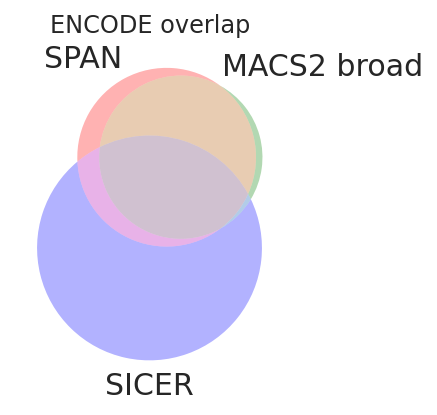

BCell  Roadmap


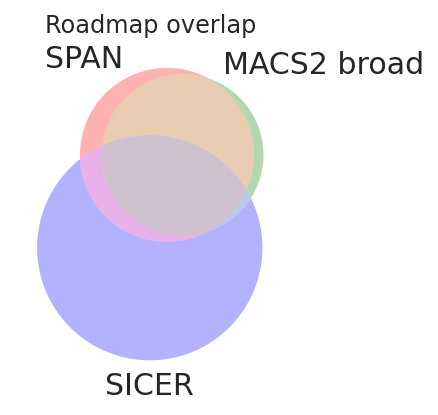

In [493]:
for cell, rep, name, df in [('GM12878', 'rep1', 'ENCODE', df_peaks),
                            ('BCell', '', 'Roadmap', df_immune_peaks)]:
    print(cell, rep, name)

    span_file = df[(df['cell'] == cell) & (df['replicate'] == rep) &
                    (df['tool'] == 'SPAN')]['file'].values[0]
    macs2_broad_file = df[(df['cell'] == cell) & (df['replicate'] == rep) &
                          (df['tool'] == 'MACS2 broad')]['file'].values[0]
    sicer_file = df[(df['cell'] == cell) & (df['replicate'] == rep) &
                    (df['tool'] == 'SICER')]['file'].values[0]


    tf = tempfile.mktemp()
    ! bedtools multiinter -i {span_file} {macs2_broad_file} {sicer_file} > {tf}
    t = pd.read_csv(tf, sep='\t', names=['chr', 'start', 'end',
                                         'overlap_number', 'overlap_details',
                                         'overlap1', 'overlap2', 'overlap3'])
    plt.figure(figsize=(3, 3))
    ax = plt.axes()
    venn3_overlap(ax, *[
        (t[t['overlap_details'] == o]['end'] - t[t['overlap_details'] == o]['start']).sum()
        # (t['overlap_details'] == o).sum() 
        for o in VENN3_SUBSETS
    ], 'SPAN', 'MACS2 broad', 'SICER', show_numbers=False, engineer=True)
    plt.title(f'{name} overlap')
    plt.tight_layout()
    plt.show()

## Percentiles estimation versus 1000bp domains

In [497]:
tf = tempfile.mktemp()
tf2 = tempfile.mktemp()

perc_len_dfs = []
perc_peaks_df = pd.DataFrame(columns=['cell', 'replicate', 'length', 'tool', 'peaks'], dtype=object)

for cell, rep, name, df in [('GM12878', 'rep1', 'ENCODE', df_peaks),
                            ('BCell', '', 'Roadmap', df_immune_peaks)]:
    print(cell, rep, name)
    
    for tool in TOOLS:
        peaks_file = df[(df['cell'] == cell) & (df['replicate'] == rep) &
                        (df['tool'] == tool)]['file'].values[0]
        bins_file = df_bins[(df_bins['cell'] == cell) & (df_bins['replicate'] == rep)
                            & (df_bins['tool'] == tool) & (df_bins['bin'] == 1000)]['file'].values[0]
        t = pd.read_csv(bins_file, sep='\t', header=None, usecols=[0, 1, 2])
        t[3] = t[2] - t[1]
        t.sort_values(by=[3, 0, 1, 2], inplace=True)
        # Take % peaks by lengths and compute ratios inside
        step = 20
        for percentage in [0, 20, 40, 60, 80]:
            percentage_name = f'{percentage}%-{percentage + step}%'
            t.iloc[int(len(t) * percentage / 100):int(len(t) * (percentage + step) / 100)][[0, 1, 2]].to_csv(
                tf, sep='\t', index=False, header=None
            )
            # Prepare tool percentage peaks
            ! bedtools intersect -wa -u -a {sorted_file(peaks_file)} -b {sorted_file(tf)} > {tf2}
            peak_lengths = bedl(tf2)
            tl = pd.DataFrame(dict(peak_lengths=peak_lengths))
            tl = tl.sample(min(len(tl), 10_000))
            tl['name'] = tool
            tl['cell'] = cell
            tl['replicate'] = rep
            tl['length'] = percentage_name
            perc_peaks_df.loc[len(perc_peaks_df)] = (cell, rep, percentage_name, tool, len(peak_lengths))
            perc_len_dfs.append(tl)

display(perc_peaks_df.sample(3))
perc_len_df = pd.concat(perc_len_dfs).reset_index(drop=True)
del perc_len_dfs
display(perc_len_df.sample(3))

GM12878 rep1 ENCODE
BCell  Roadmap


,cell,replicate,length,tool,peaks
16,GM12878,rep1,20%-40%,SPAN,6453
37,BCell,,40%-60%,SPAN,4977
34,BCell,,80%-100%,SICER,6224


,peak_lengths,name,cell,replicate,length
191533,1502,MACS2 broad,BCell,,40%-60%
108608,1586,SPAN,GM12878,rep1,0%-20%
65618,6812,MACS2 broad,GM12878,rep1,80%-100%


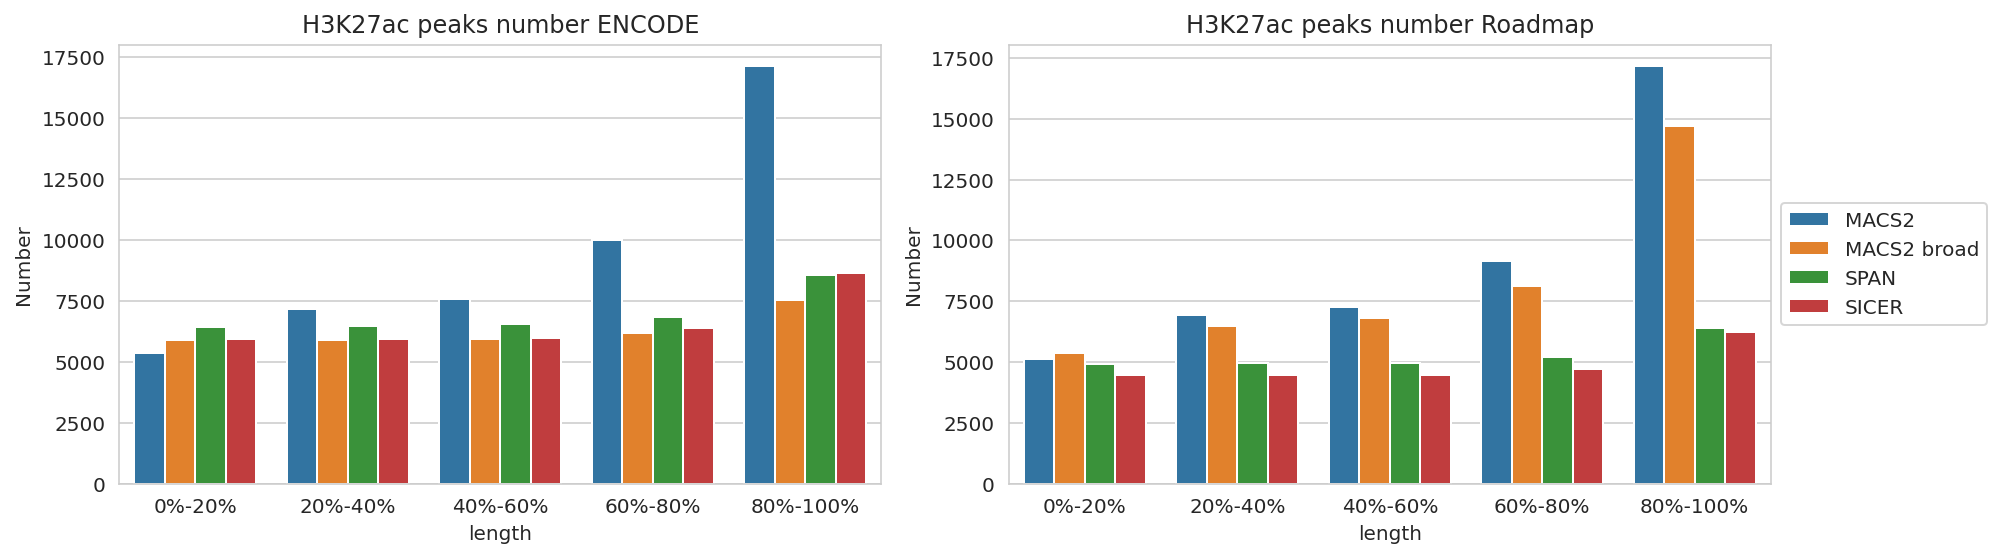

In [501]:
plt.figure(figsize=(14, 4))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
ax = axs[0]
g_results = sns.barplot(data=perc_peaks_df[perc_peaks_df['cell'] == 'GM12878'],
                        y='peaks', x='length', ax=ax,
                        hue='tool',
                        hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        palette=TOOLS_PALETTE,
                        )
ax.title.set_text('H3K27ac peaks number ENCODE')
g_results.axes.set_ylabel('Number')
ax.legend().set_visible(False)

ax = axs[1]
g_results = sns.barplot(data=perc_peaks_df[perc_peaks_df['cell'] == 'BCell'],
                        y='peaks', x='length', ax=ax,
                        hue='tool',
                        hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        palette=TOOLS_PALETTE,
                        )
ax.title.set_text('H3K27ac peaks number Roadmap')
g_results.axes.set_ylabel('Number')
# Put a legend to the right of the current axis
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

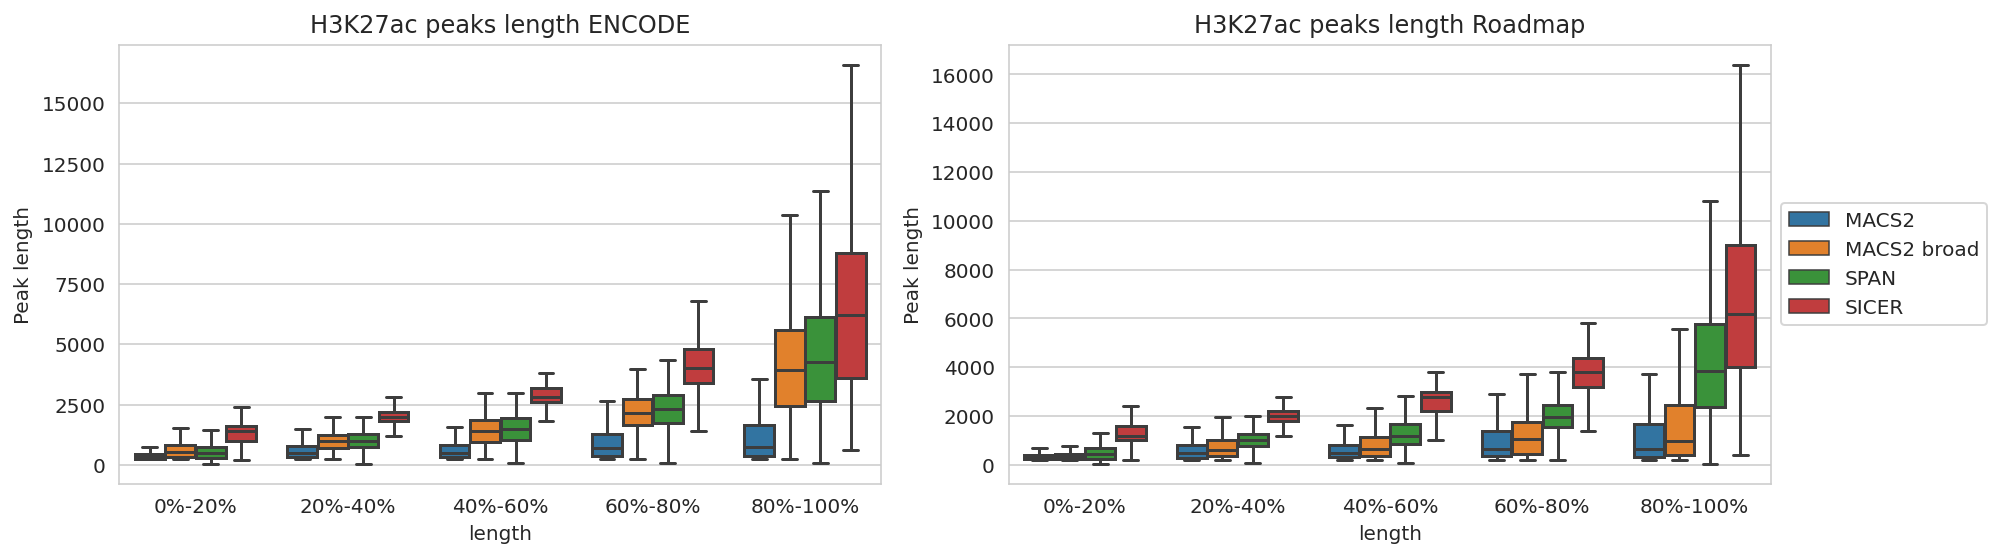

In [505]:
plt.figure(figsize=(14, 4))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
ax = axs[0]
g_results = sns.boxplot(data=perc_len_df[perc_len_df['cell'] == 'GM12878'], 
                        x='length', y='peak_lengths',
                        ax=ax,
                        hue='name',
                        hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        palette=TOOLS_PALETTE,
                        showfliers=False)
ax.title.set_text('H3K27ac peaks length ENCODE')
g_results.axes.set_ylabel('Peak length')
ax.legend().set_visible(False)

ax = axs[1]
g_results = sns.boxplot(data=perc_len_df[perc_len_df['cell'] == 'BCell'], 
                        x='length', y='peak_lengths', 
                        ax=ax,
                        hue='name',
                        hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        palette=TOOLS_PALETTE,
                        showfliers=False)
ax.title.set_text('H3K27ac peaks length Roadmap')
g_results.axes.set_ylabel('Peak length')
# Put a legend to the right of the current axis
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()


# END